# Plot terminus picks over images analyzed and terminus position timeseries

#### Jukes Liu

## 1) Import packages, set paths, and read in csv files

In [67]:
# import sys
# # !{sys.executable} -m pip install fiona
# !{sys.executable} -m pip install opencv-python

In [121]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import cv2
import pandas as pd    
from time import sleep
from IPython.display import clear_output
import scipy.stats
import datetime
import shutil

csvpaths = '/home/jukes/Documents/Sample_glaciers/'
basepath = '/media/jukes/jukes1/LS8aws/'
massorsize = "mass"

Read in __image dates__ from imgdates.csv

In [122]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(csvpaths+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(datetime_df.shape)
datetime_df.head()

(864, 2)


Scene   datetimes
510   LC80090132013101LGN01  2013-04-11
1612  LC80090142013101LGN01  2013-04-11
577   LC82330172013102LGN01  2013-04-12
940   LC82330152013102LGN01  2013-04-12
445   LC80080142013110LGN01  2013-04-20

Read in csv with the __metric and order__ for each terminus pick from terminuspicks_massorsize_date.csv

In [123]:
analysis_date = '2019_10_24'

order_df = pd.read_csv(csvpaths+'terminuspicks_'+massorsize+'_'+analysis_date+'.csv', sep=',', dtype=str, header=1, usecols=[0,1,2,3,4])
order_df = order_df.dropna()
print(order_df.shape)
order_df.head(10)

(5232, 5)


BoxID                  Scene Scale       Scaled_Mass Order
0   001  LC80310052014242LGN00   004   5600.5618286133     5
1   001  LC80310052014242LGN00   003   8399.8723754883     4
2   001  LC80310052014242LGN00   002  16463.2495117188     3
3   001  LC80310052014242LGN00   001  32791.9229736328     2
4   001  LC80310052014242LGN00   000  66196.5776367188     1
5   001  LC80310052014226LGN00   043      0.0000000066     5
6   001  LC80310052014226LGN00   041      0.0000000288     4
7   001  LC80310052014226LGN00   002  20833.6751403809     3
8   001  LC80310052014226LGN00   001  42189.2700195312     2
9   001  LC80310052014226LGN00   000  90920.1655273438     1

Read in __centerline information__ for each terminus box rom Boxes_coords_pathrows.csv

In [124]:
centerline_df = pd.read_csv(csvpaths+'Boxes_coords_pathrows.csv', sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')
print(centerline_df.shape)
centerline_df

(10, 4)


midpoint_x midpoint_y            cline_slope     cline_intercept
BoxID                                                                 
001        117.0      164.5   -0.11888111888111888   178.4090909090909
002        468.0      575.5    0.03345070422535211   559.8450704225352
004        500.0      651.0    -0.2899305555555556   795.9652777777778
033        362.5      473.0  -0.006185567010309278  475.24226804123714
120        111.0      148.5   0.055944055944055944   142.2902097902098
174        260.5      344.5    -0.3231939163498099   428.6920152091255
235        177.0      201.0     0.2222222222222222  161.66666666666669
259        215.0      484.0     0.0705521472392638   468.8312883435583
277        144.5      204.0   -0.04891304347826087   211.0679347826087
531        166.0      250.5   -0.15637860082304528   276.4588477366255

Read in __glacier velocities__ from Glacier_velocities.csv

In [125]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv(csvpaths+'Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

## 2) Plot analyzed images and terminus picks for one glacier sequentially

If images have not been converted to png from pgm, run the following cell but change the BoxID to the right ID:

In [617]:
%%bash

cd /media/jukes/jukes1/LS8aws/Box277/resized/
mogrify -format png *.pgm

#### Load in the images, scene names, and dat file names for all the resulting terminus picks

In [159]:
BOI= '120'
print("Box"+BOI)

metric = "terminus_highest"+massorsize+"/"
imagepath = basepath+"Box"+BOI+"/resized/"

#grab the order_df subset for just the box:
order_box_df = order_df[order_df["BoxID"]==BOI].copy()

#make results directory in BoxID folder if it doesn't already exist
if os.path.exists(basepath+"Box"+BOI+"/Results/"):
    shutil.rmtree(basepath+"Box"+BOI+"/Results/")
    print("Results folder wiped and new created")
    os.mkdir(basepath+"Box"+BOI+"/Results/")
#OTHERWISE, create the folder and download into it
else:
    os.mkdir(basepath+"Box"+BOI+"/Results/")
    print("Results  folder made")

Box120
Results folder wiped and new created


Drop BoxID column and NaNs from the order_box_df

In [160]:
order_box_df = order_box_df.drop('BoxID', axis=1)
order_box_df = order_box_df.dropna()
print(order_box_df.shape)
order_box_df.head()

(500, 4)


Scene Scale        Scaled_Mass Order
2172  LC82320182016312LGN00   004    8232.6941680908     5
2173  LC82320182016312LGN00   003   16801.0856933594     4
2174  LC82320182016312LGN00   002   35005.0078125000     3
2175  LC82320182016312LGN00   001   69297.7030639648     2
2176  LC82320182016312LGN00   000  144254.2645263672     1

In [161]:
#make lists to store image data and grab image files
image_arrays = []
dats = []
trimdats = []
imgnames = []
boxids = []
scales = []

#image path
imgfiles = os.listdir(imagepath)

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
#         print(imgfile)
        image = mpimg.imread(imagepath+imgfile)
        imgname = imgfile[0:-4]
        scenename = imgname[7:-16]
#         print(imgname, scenename)
        
        pathtodat = imagepath+imgname+".pgm_max_gaussian/"+metric
        datfiles = os.listdir(pathtodat)
        
        #if there are datfiles, grab the trimmed and non-trimmed files
        if len(datfiles) > 1: 
            #find the trimmed dat file and the original
            for dat in datfiles:
                if "trim" in dat:
                    datfile_trim = dat
                    #append to trimmed dats list
                    trimdats.append(datfile_trim)
                    #grab the scale and append the equivalent original dat
                    scale = dat[-7:-4]
                    datfile = "terminus_"+scale+".dat"
                    dats.append(datfile)
                    
                    #append the image array and the image name to the list
                    image_arrays.append(image)
                    imgnames.append(scenename)
                    boxids.append(BOI)
                    scales.append(scale)

print(len(image_arrays), len(dats), len(trimdats), len(imgnames),len(boxids), len(scales))
images_df = pd.DataFrame(list(zip(imgnames, boxids, image_arrays, dats, trimdats, scales)),
              columns=['Scene','BoxID','Image_array', 'Dat_filename', "Trimmed_dat_filename", "Scale"])

500 500 500 500 500 500


In [162]:
print(images_df.shape)
images_df.head(15)

(500, 6)


Scene BoxID  \
0   LC82330172014041LGN00   120   
1   LC82330172014041LGN00   120   
2   LC82330172014041LGN00   120   
3   LC82330172014041LGN00   120   
4   LC82330172014041LGN00   120   
5   LC82320182015149LGN00   120   
6   LC82320182015149LGN00   120   
7   LC82320182015149LGN00   120   
8   LC82320182015149LGN00   120   
9   LC82320182015149LGN00   120   
10  LC82330172015300LGN00   120   
11  LC82330172015300LGN00   120   
12  LC82330172015300LGN00   120   
13  LC82330172015300LGN00   120   
14  LC82330172015300LGN00   120   

                                          Image_array      Dat_filename  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_004.dat   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_004.dat   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   
11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
12  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
13  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_004.dat   

     Trimmed_dat_filename Scale  
0   terminus_trim_002.dat   002  
1   terminus_trim_001.dat   001  
2   terminus_trim_003.dat   003  
3   terminus_trim_000.dat   000  
4   terminus_trim_004.dat   004  
5   terminus_trim_002.dat   002  
6   terminus_trim_001.dat   001  
7   terminus_trim_003.dat   003  
8   terminus_trim_000.dat   000  
9   terminus_trim_004.dat   004  
10  terminus_trim_002.dat   002  
11  terminus_trim_001.dat   001  
12  terminus_trim_003.dat   003  
13  terminus_trim_000.dat   000  
14  terminus_trim_004.dat   004

#### Join dates to images_df by joining on Scene:

In [163]:
images_df.sort_values(by='Scene')
datetime_df = datetime_df.sort_values(by='Scene')
print(datetime_df.shape)

(864, 2)


In [164]:
new_df = images_df.merge(datetime_df, how= 'inner', on = 'Scene')
#sort by ascending datetime
dated_images_df = new_df.sort_values(by='datetimes', ascending = True)
#check the shape
print(dated_images_df.shape)
dated_images_df.head()

(500, 7)


Scene BoxID  \
444  LC82330172013102LGN01   120   
443  LC82330172013102LGN01   120   
442  LC82330172013102LGN01   120   
441  LC82330172013102LGN01   120   
440  LC82330172013102LGN01   120   

                                           Image_array      Dat_filename  \
444  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_005.dat   
443  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_004.dat   
442  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
441  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
440  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   

      Trimmed_dat_filename Scale   datetimes  
444  terminus_trim_005.dat   005  2013-04-12  
443  terminus_trim_004.dat   004  2013-04-12  
442  terminus_trim_000.dat   000  2013-04-12  
441  terminus_trim_001.dat   001  2013-04-12  
440  terminus_trim_002.dat   002  2013-04-12

#### Join "order" to dated_images_df by joining on scale and scene

In [165]:
final_images_df = dated_images_df.merge(order_box_df, how='inner', on=['Scene', 'Scale'])
final_images_df.head()

Scene BoxID  \
0  LC82330172013102LGN01   120   
1  LC82330172013102LGN01   120   
2  LC82330172013102LGN01   120   
3  LC82330172013102LGN01   120   
4  LC82330172013102LGN01   120   

                                         Image_array      Dat_filename  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_005.dat   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_004.dat   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   

    Trimmed_dat_filename Scale   datetimes        Scaled_Mass Order  
0  terminus_trim_005.dat   005  2013-04-12    5625.8708190918     5  
1  terminus_trim_004.dat   004  2013-04-12   11315.0952301025     4  
2  terminus_trim_000.dat   000  2013-04-12  192274.8242187500     1  
3  terminus_trim_001.dat   001  2013-04-12   97245.6152343750     2  
4  terminus_trim_002.dat   002  2013-04-12   48195.8210449219     3

#### Sort the dataframe and grab the unique scenes

In [166]:
#sort the DataFrame by date of delineation from earliest to latest AND order
final_images_df = final_images_df.sort_values(by=['datetimes','Scene','Order'], ascending=True)

## Calculate terminus positions and terminus change rates by glacier

### Terminus position:

In [167]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [237]:
#LOAD IN REFERENCE POINT to calculate terminus position with respect to
box_midpoint_x = np.float(centerline_df.loc[BOI, 'midpoint_x'])

#GRAB CENTERLINE POINTS
#grab slope and intercept from the dataframe
c_slope = float(centerline_df.loc[BOI]['cline_slope'])
c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
#Read in terminus box raster as an np array
tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.png")
#grab x values from width of the terminus box:
xmin = float(centerline_df.loc[BOI]['midpoint_x'])
xmax = np.max(np.array(list(set(np.nonzero(tbox)[0]))))
c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
c_y = c_slope*c_x + c_intercept

#LISTS TO HOLD TERMINUS POSITIONS AND INTERSECTION POINTS
terminus_positions = []
intersections = []

#for each scene and scale:
for index, row in final_images_df.iterrows():
    trimdat = row['Trimmed_dat_filename']
    dat = row['Dat_filename']
    scene = row['Scene']
    
    #CALCULATE TERMINUS POSITION
    #load in dat files and calculate intersection points
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    term_trimdat = np.loadtxt(datpath+trimdat)
    term_dat = np.loadtxt(datpath+dat)                          

    intersect_xs = []
    intersect_ys = []
    #loop through all the x,y values for the centerline
    for j in range(0, len(c_x)):
        x = c_x[j]
        y = c_y[j]
        interval = 0.6
        #where are the intersections with the terminus pick?
        for dat_x, dat_y in term_trimdat:
            if within(dat_x, x, interval) and within (dat_y, y, interval):
                #intersect_x = dat_x
                #intersect_y = dat_y
                #intersect_found = True
                intersect_xs.append(dat_x)
                intersect_ys.append(dat_y)
    
    #if no intersections are found with the terminus line, append Nans
    if len(intersect_xs) == 0:
        term_position = np.NaN
        intersect_x = np.NaN
        intersect_y = np.NaN
    #if at least one is found:
    else:
        #intersection with the greatest x
        #subtract intersection_x from the box_midpoint_x to get terminus position in meters
        max_index = intersect_xs.index(np.max(intersect_xs))
        intersect_x = intersect_xs[max_index]
        intersect_y = intersect_ys[max_index]
        term_position = (intersect_x - box_midpoint_x)*15.0
    
    #append to lists
    terminus_positions.append(term_position)
    intersections.append([intersect_x, intersect_y])
    
# ADD TERMINUS POSITION AND CHANGERATES BACK INTO THE DATAFRAME
final_images_df['term_position'] = terminus_positions
final_images_df['intersections'] = intersections
print(final_images_df.shape)

(492, 12)


Drop NaNs to get rid of any terminus picks where there is no intersection with the centerline and no calculated terminus position:

In [203]:
final_images_df = final_images_df.dropna()
print(final_images_df.shape)

(492, 12)


### Terminus change rates (m/d)

#### Convert dates into datetime objects for rate calculations and timeseries plotting

In [204]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = final_images_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
final_images_df['datetimes'] = datetime_objs

ValueError: unconverted data remains:  00:00:00

In [205]:
terminus_changerates = []

#drop NaNs:
final_images_df = final_images_df.dropna()

for i in range(0, len(final_images_df.index)):
    date = list(final_images_df['datetimes'])[i]
    term_position = list(final_images_df['term_position'])[i]
    scene = list(final_images_df['Scene'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(final_images_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis 
        counter = 1
        t_prev = list(final_images_df['datetimes'])[i-counter]
        while t_prev == t:
            counter = counter+1
            t_prev = list(final_images_df['datetimes'])[i-counter]
        
        #grab all terminus positions from previous date of analysis:
        prev_df = final_images_df[final_images_df['datetimes'] == t_prev].copy()
        #grab the one that corresponds to the highest order
        highestorder = np.min(np.array(prev_df['Order']))
        if len(prev_df[prev_df['Order']==highestorder].term_position) > 1:
            x_prev = float(list(prev_df[prev_df['Order']==highestorder].term_position)[0])
        else:
            x_prev = float(prev_df[prev_df['Order']==highestorder].term_position)
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)

final_images_df['changerate'] = terminus_changerates
print(len(terminus_changerates))

492


## 3) Show each image & all (up to 5) terminus picks at a time:

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

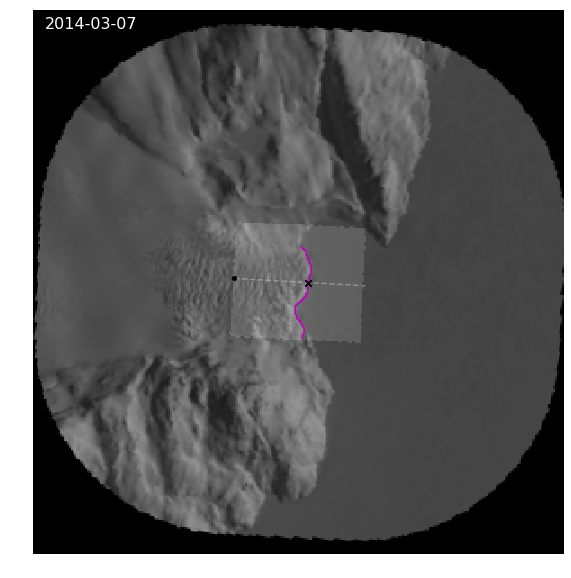

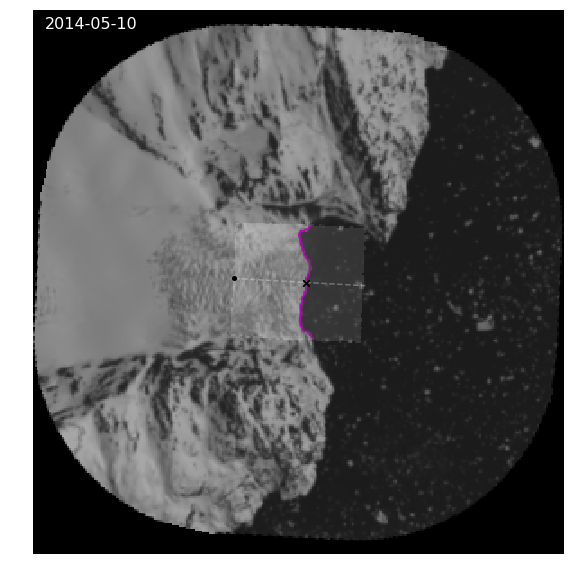

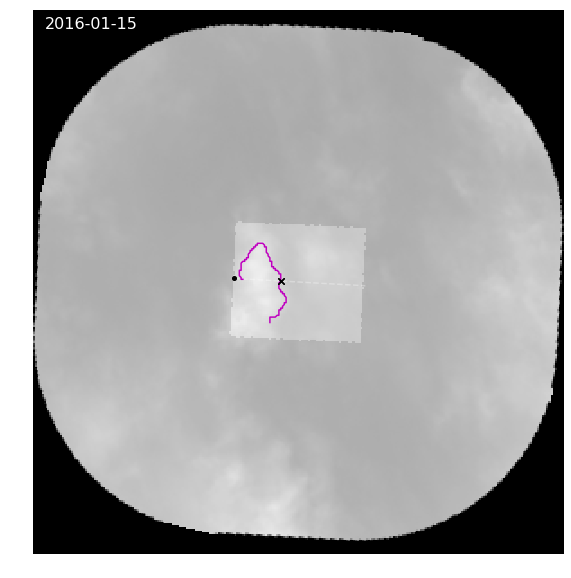

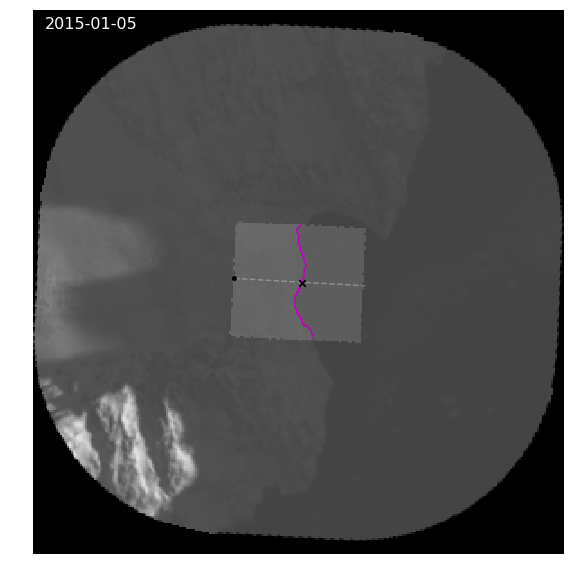

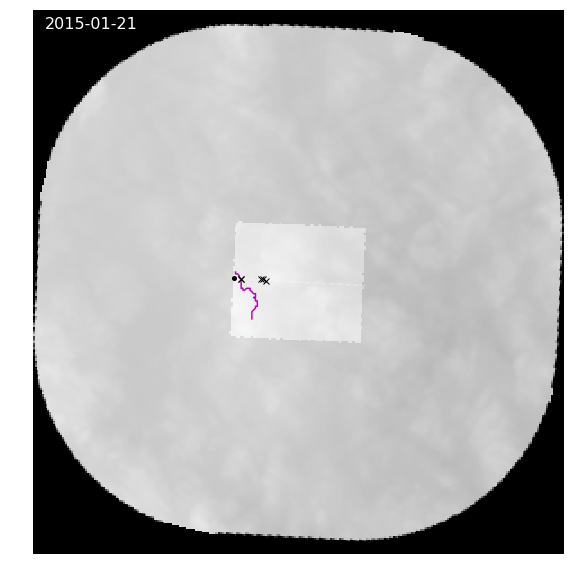

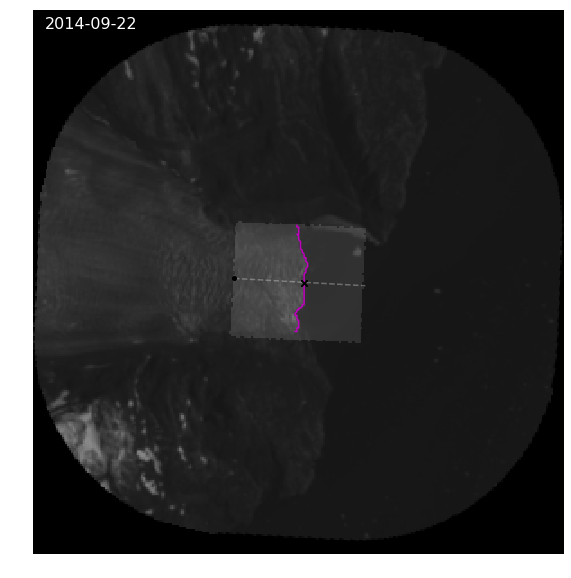

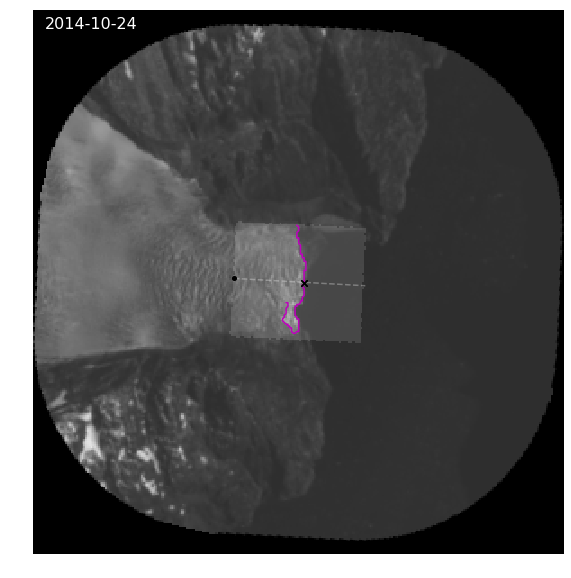

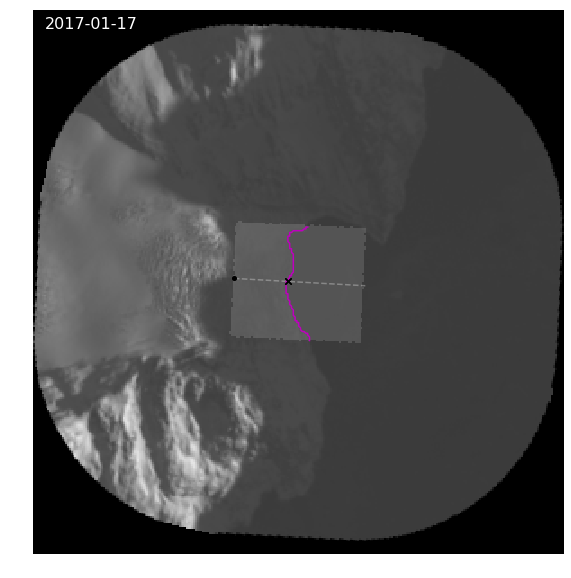

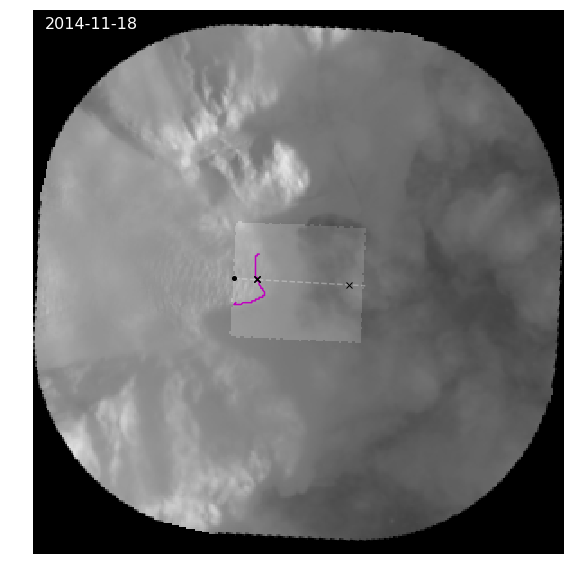

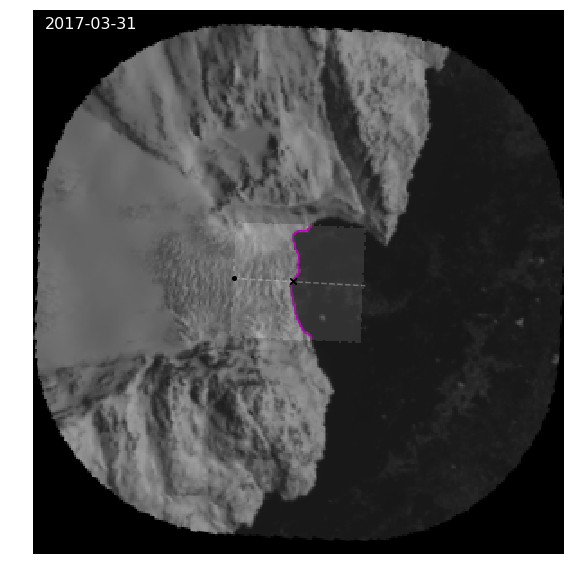

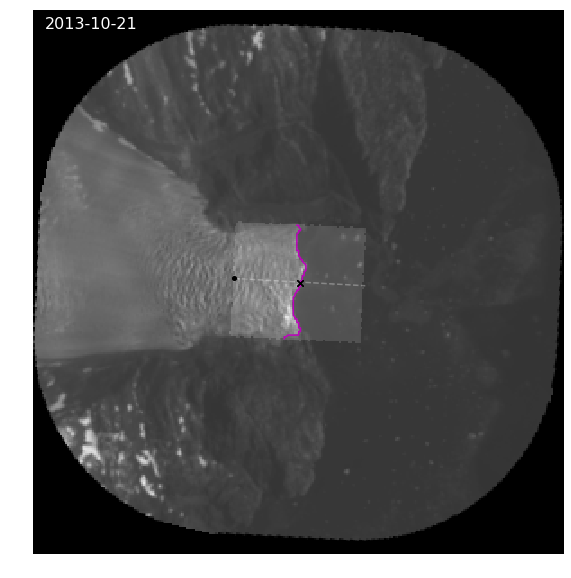

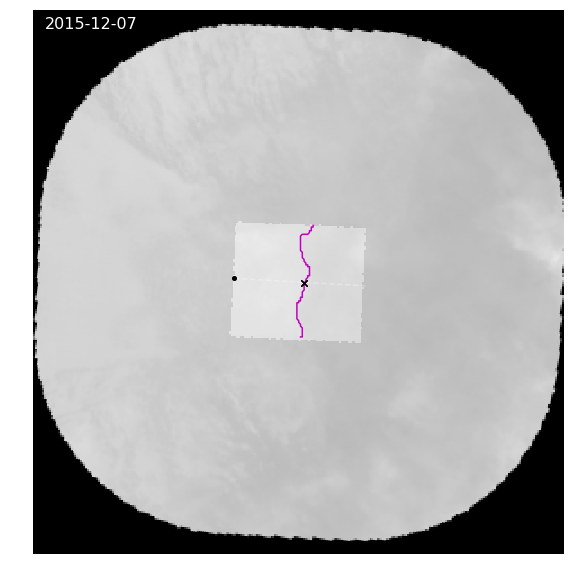

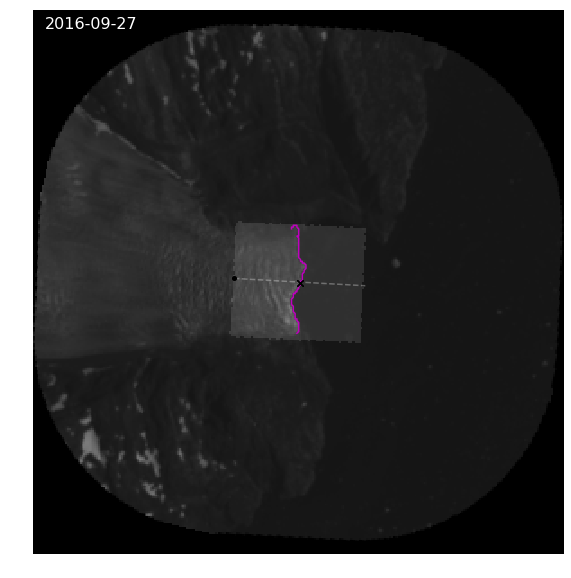

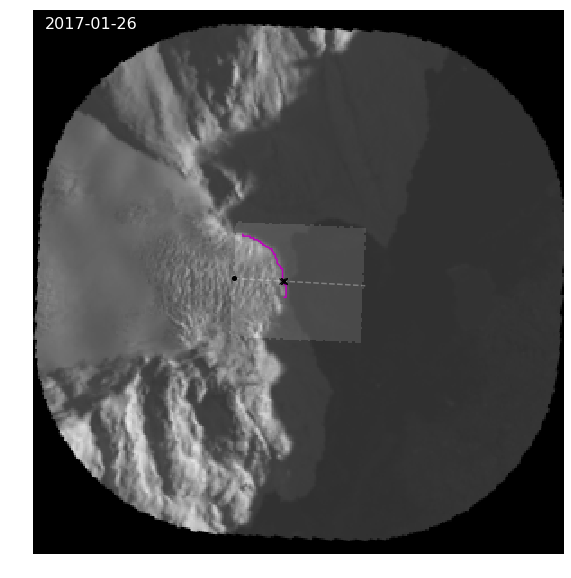

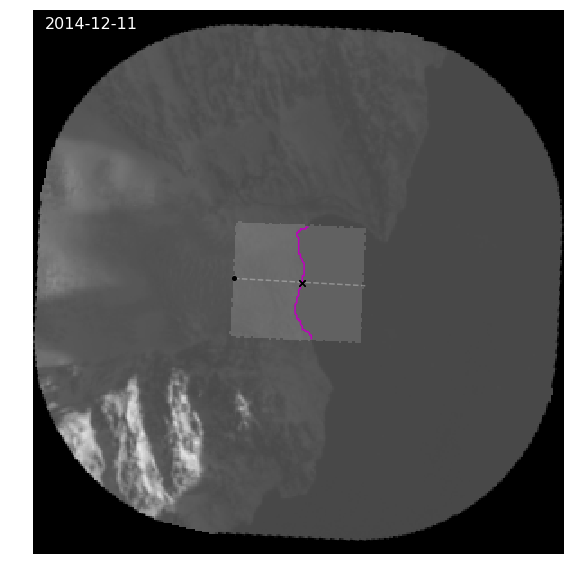

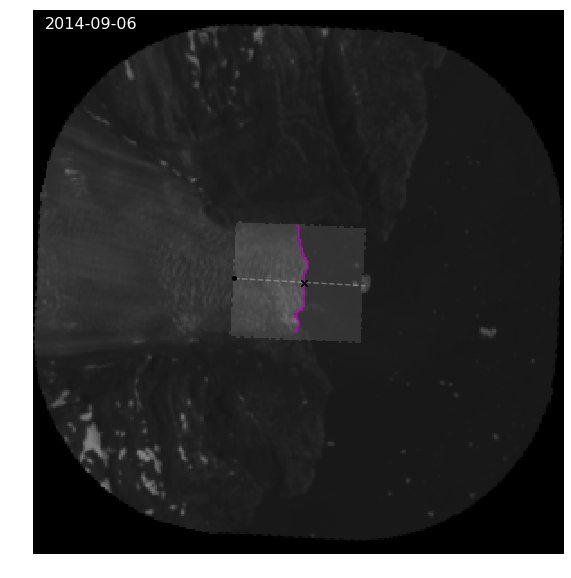

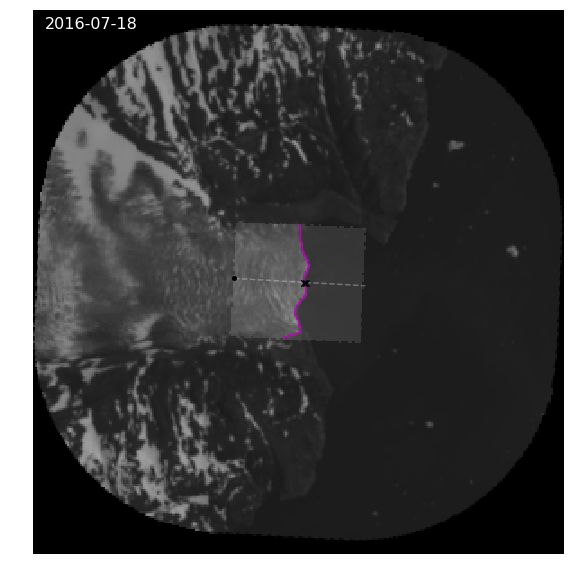

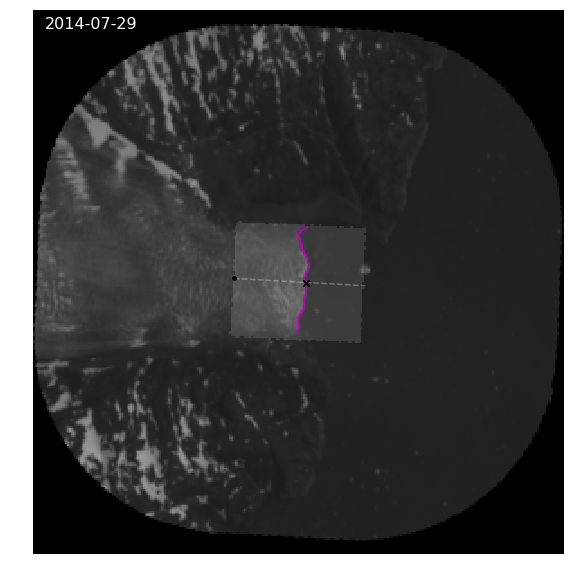

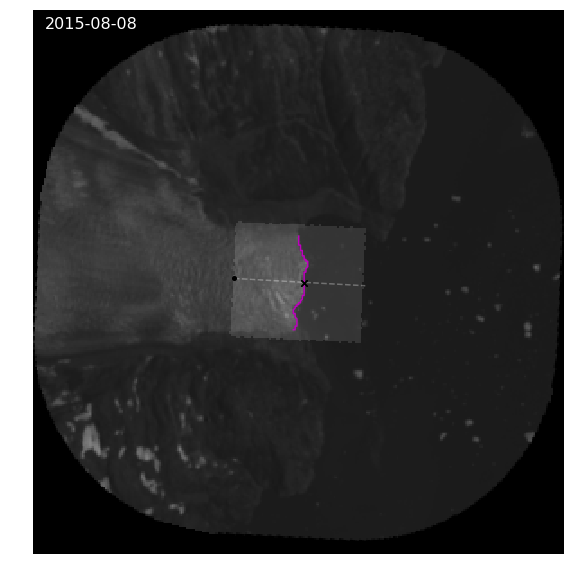

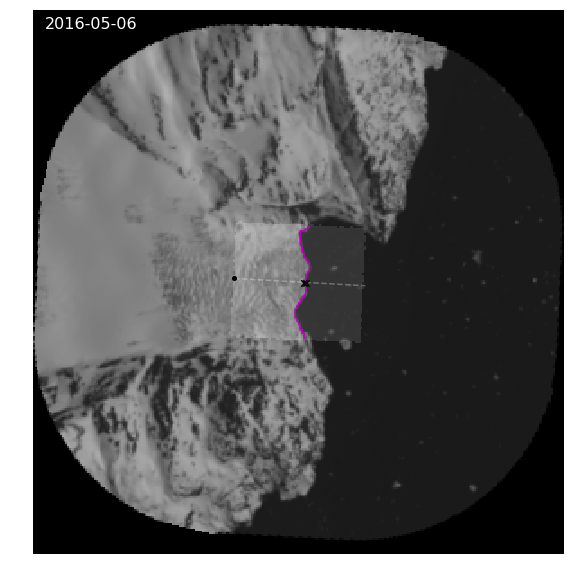

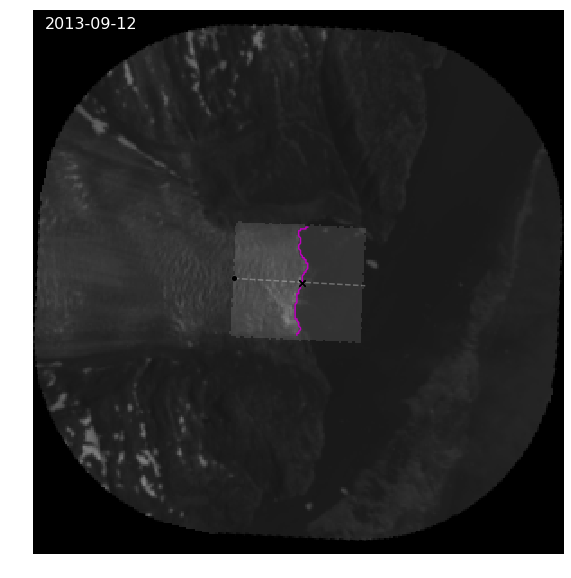

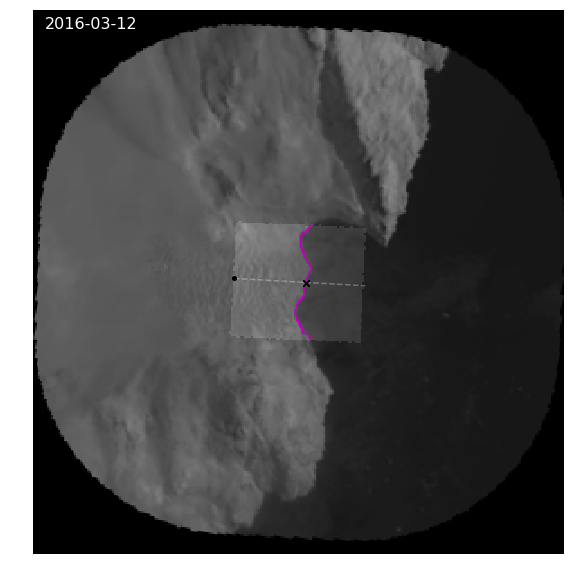

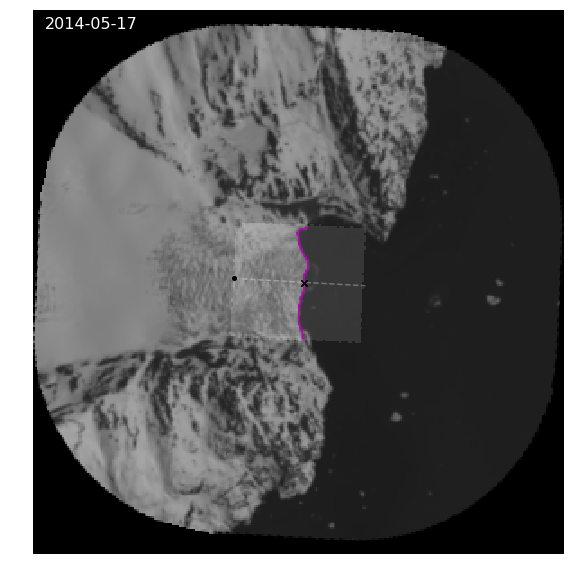

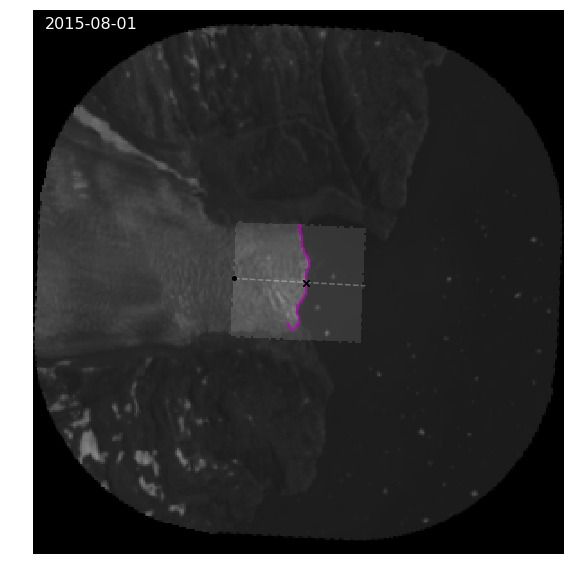

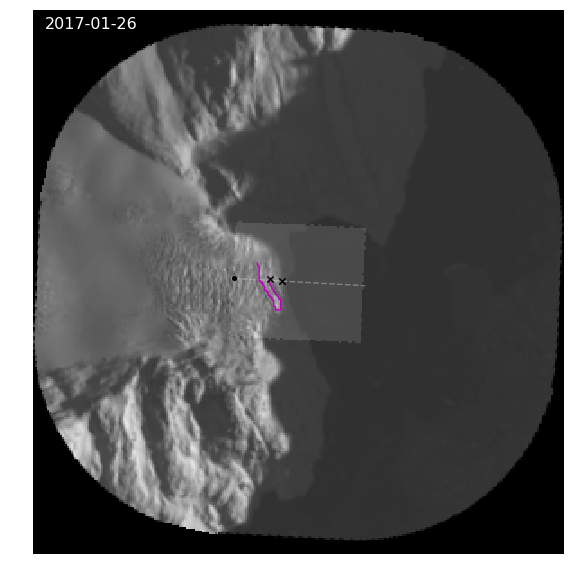

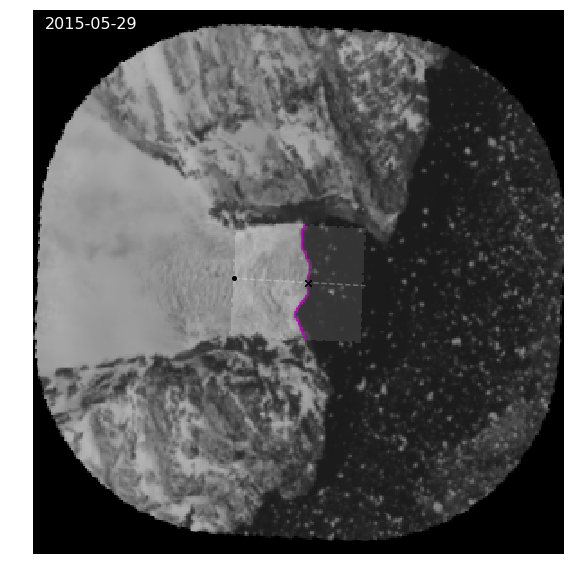

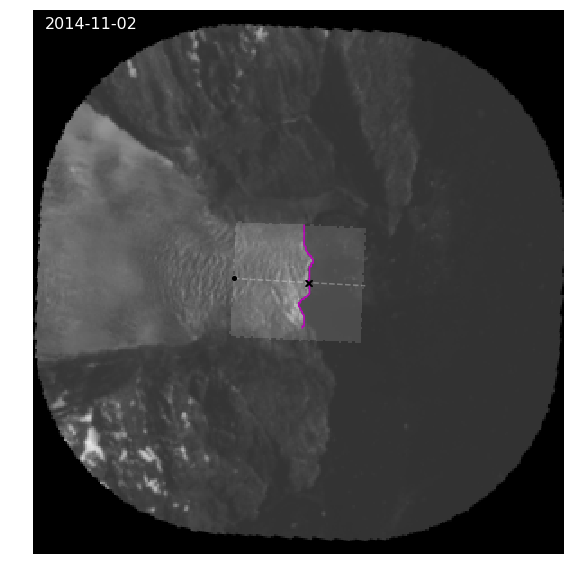

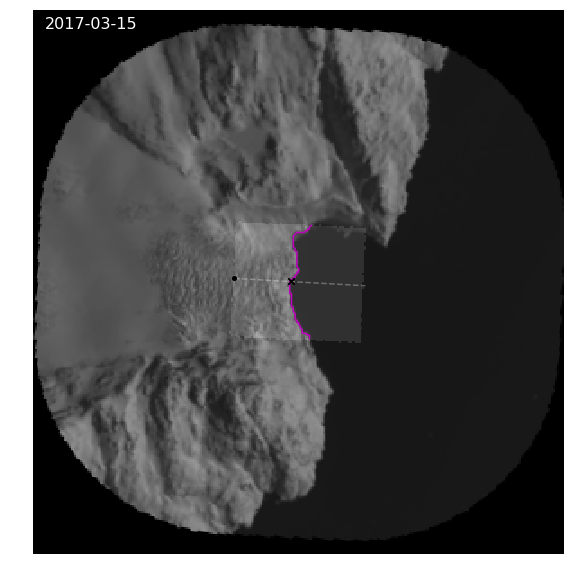

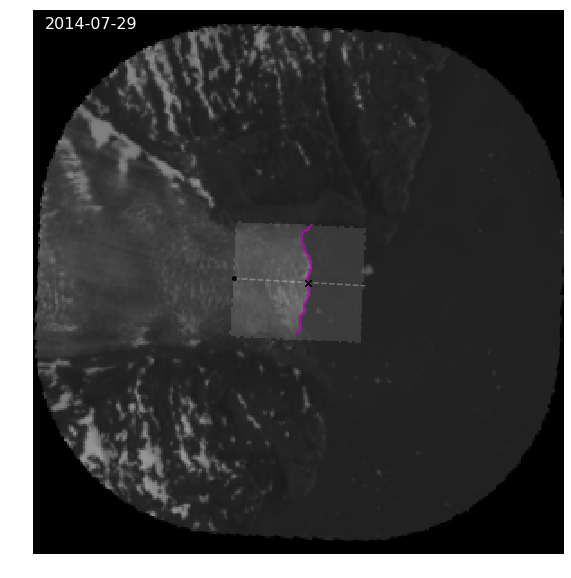

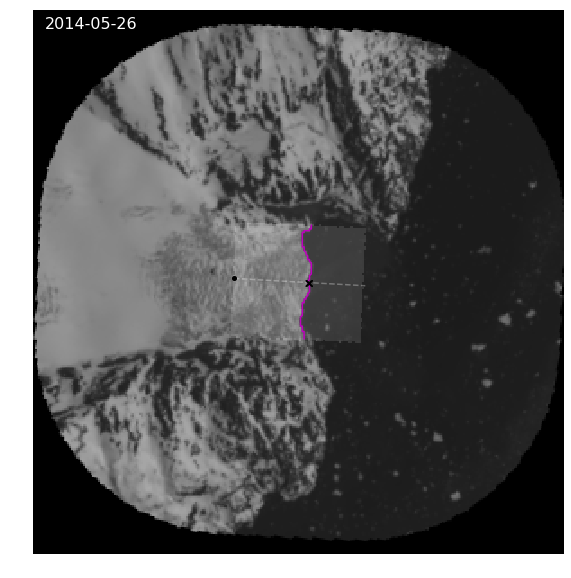

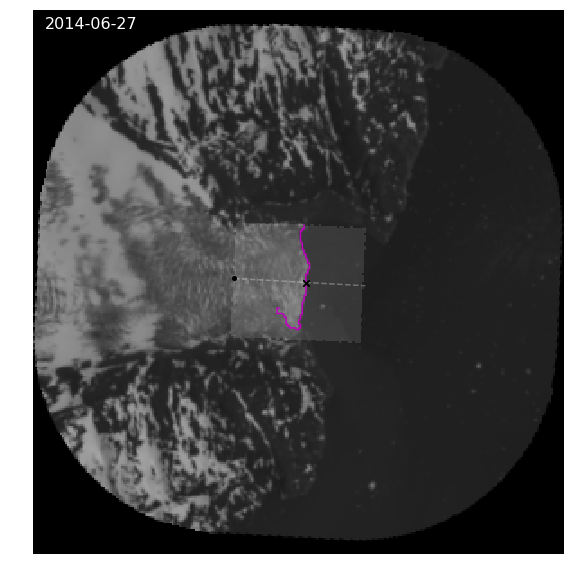

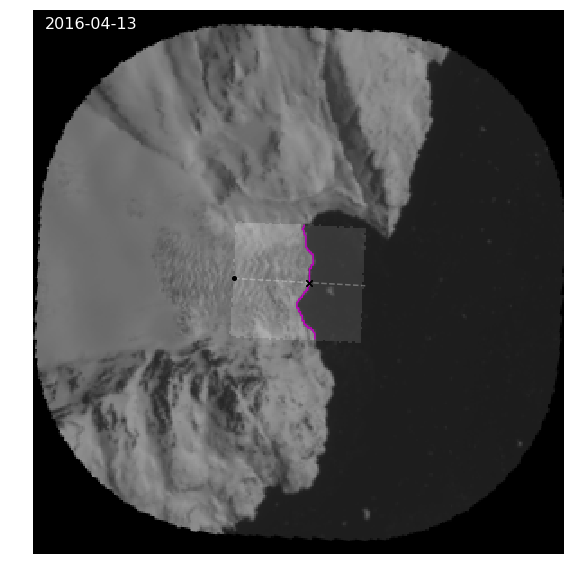

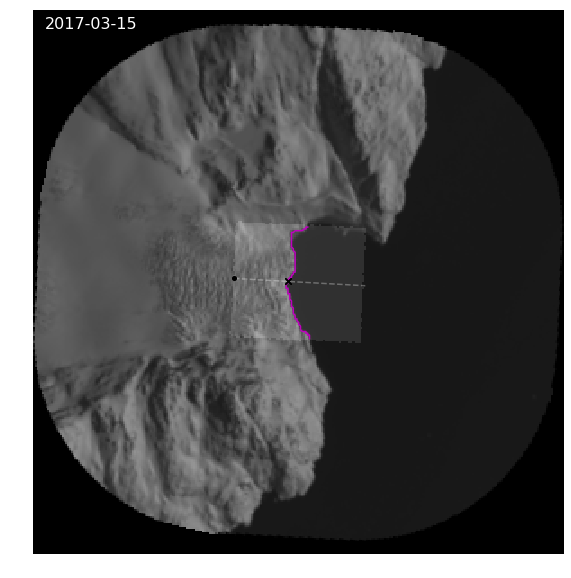

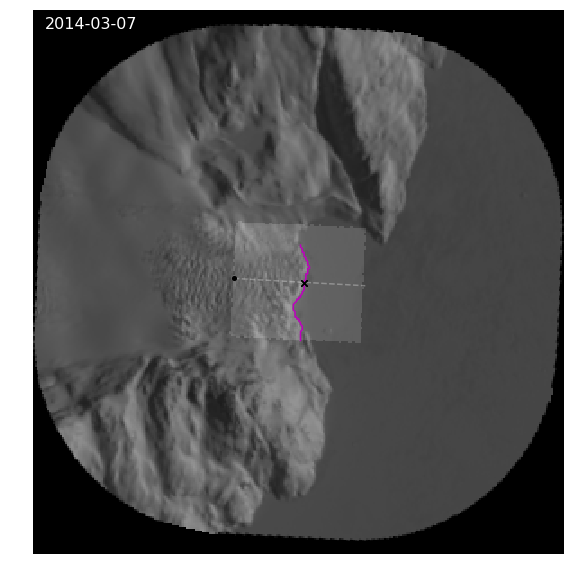

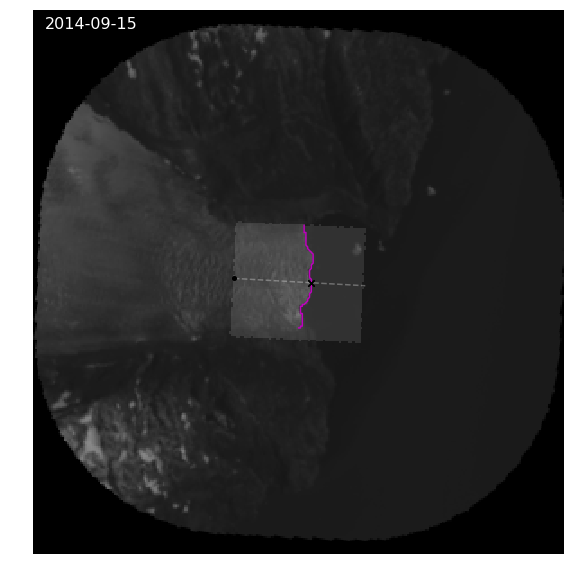

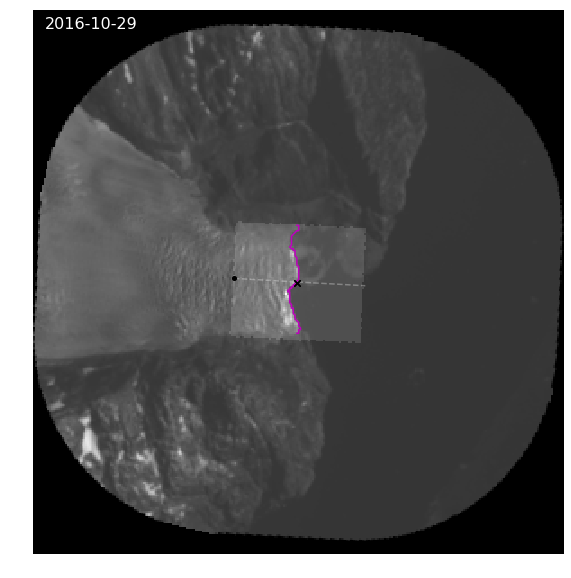

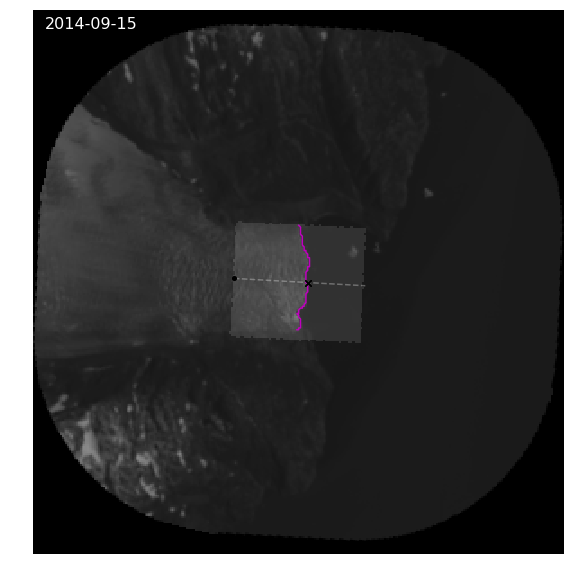

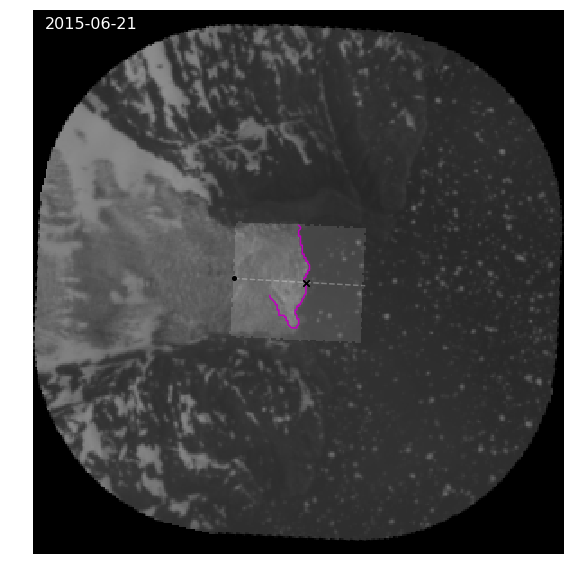

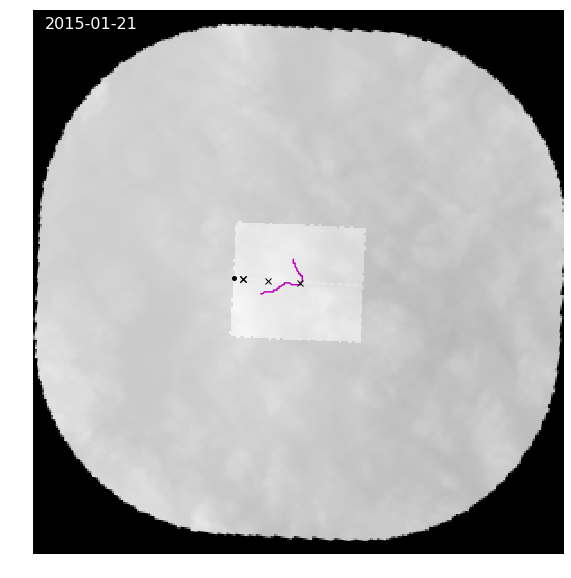

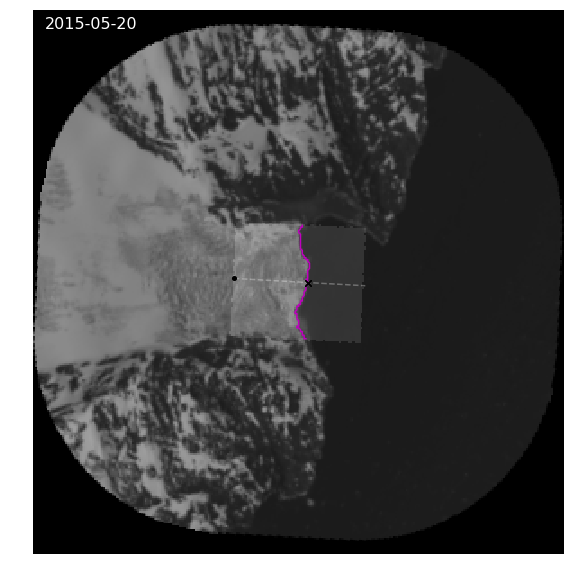

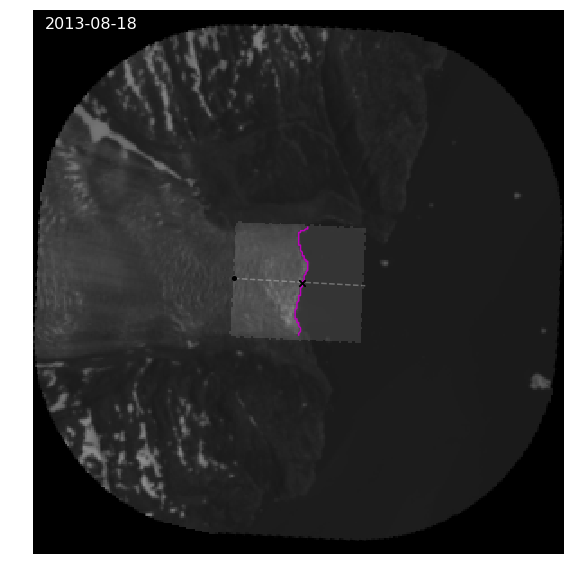

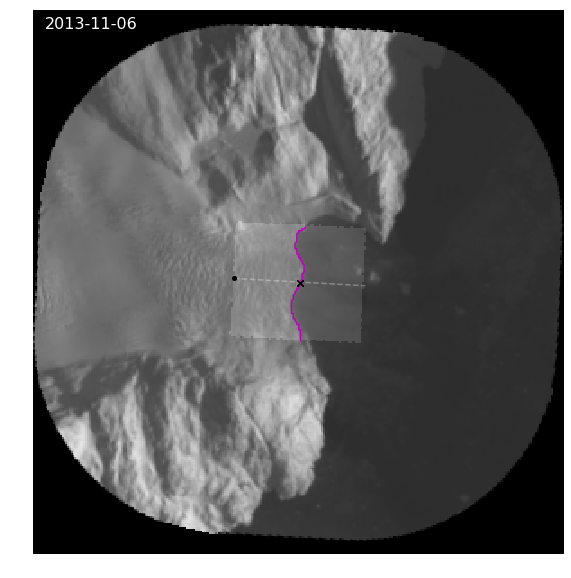

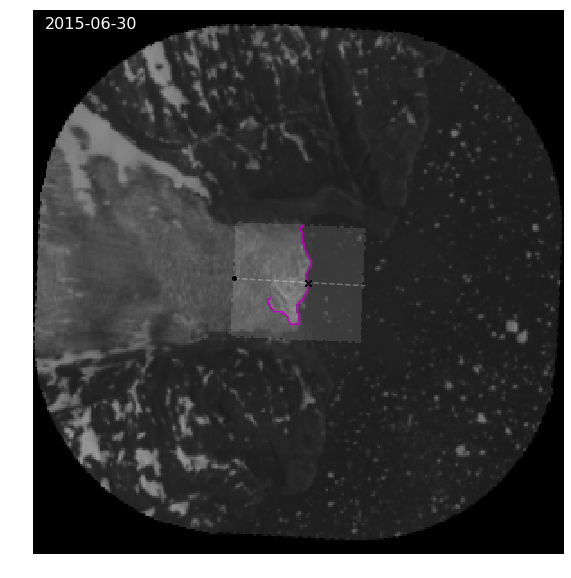

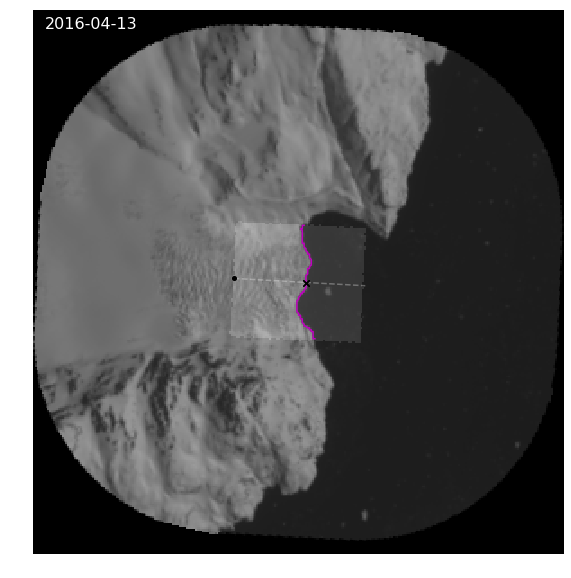

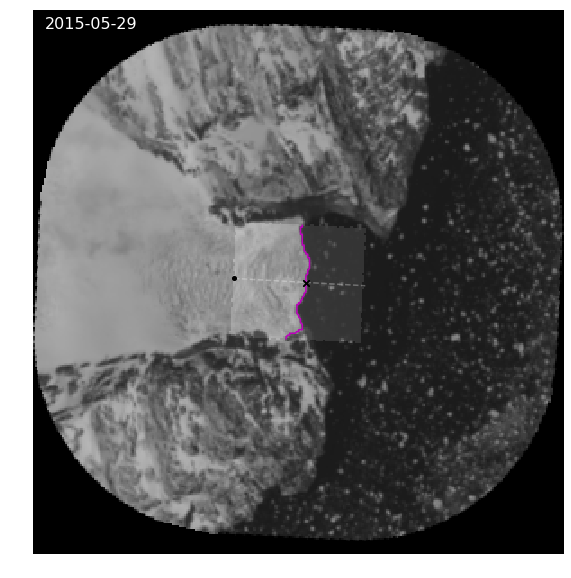

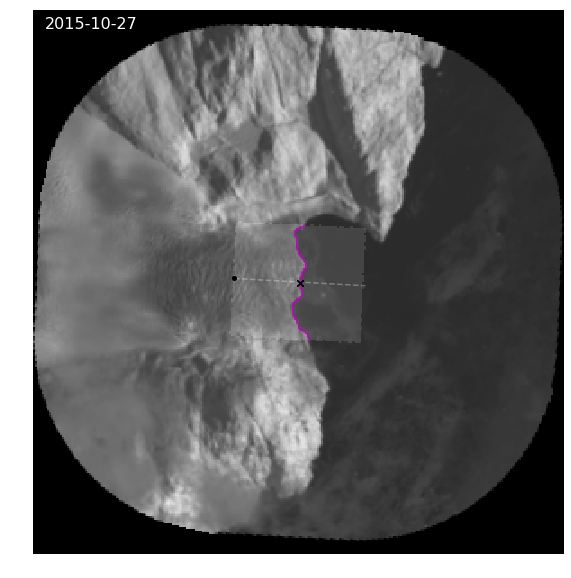

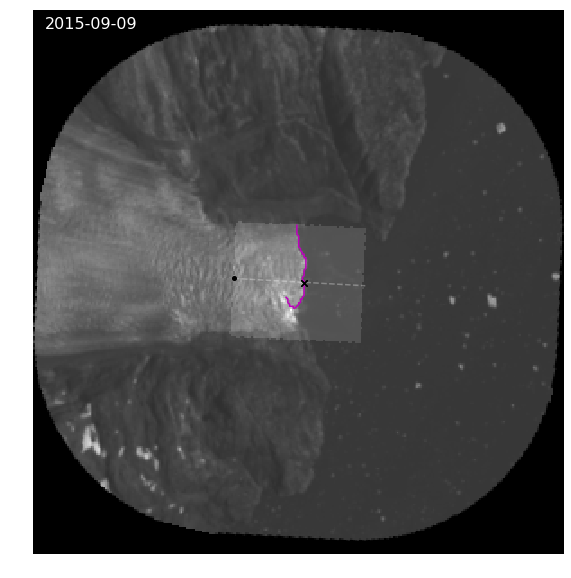

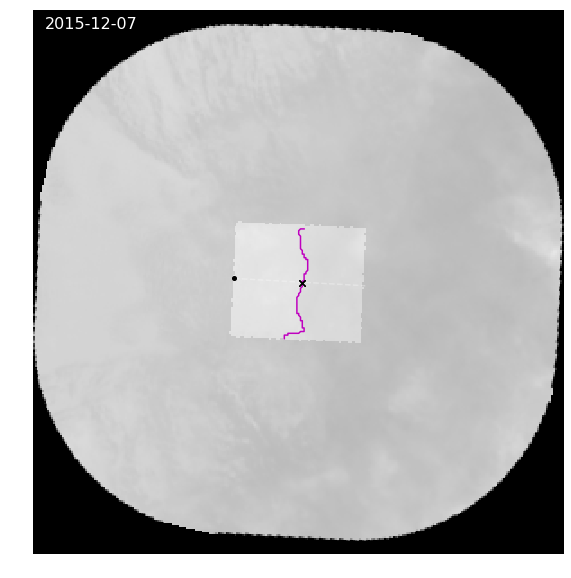

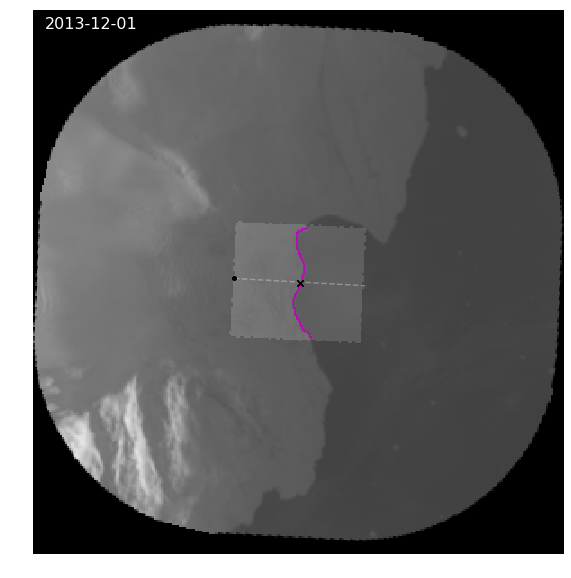

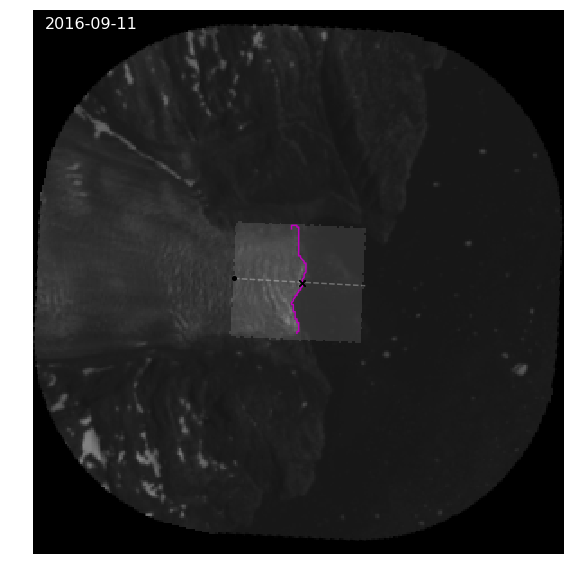

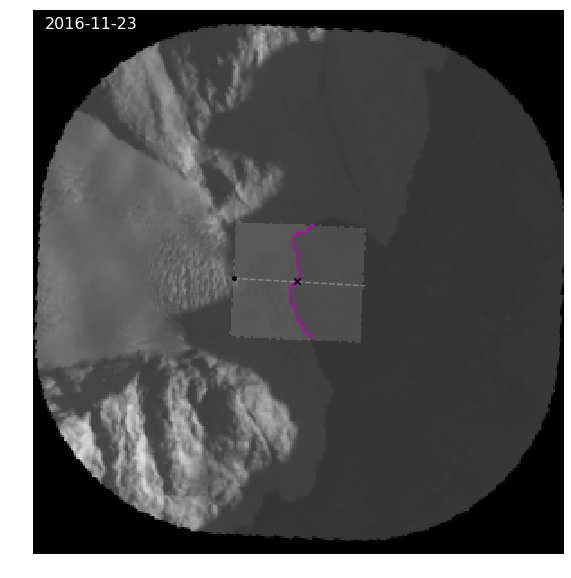

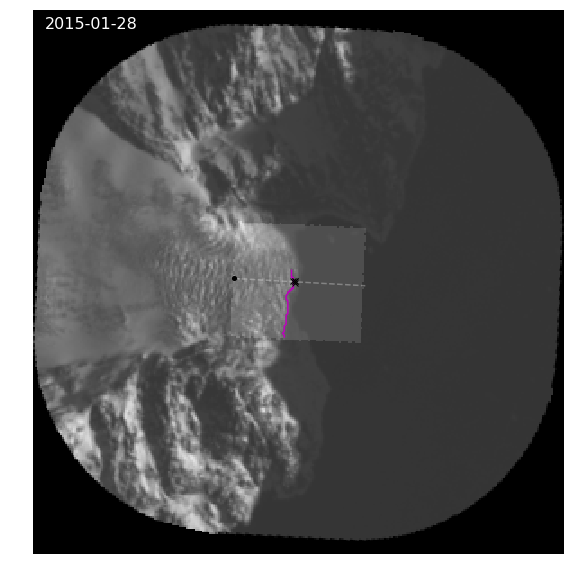

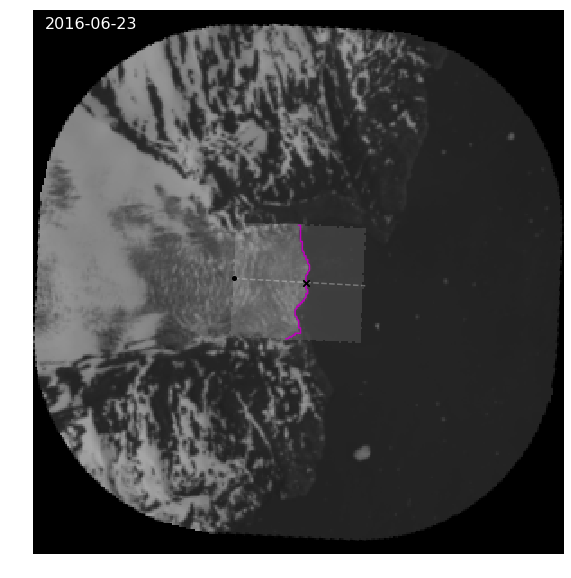

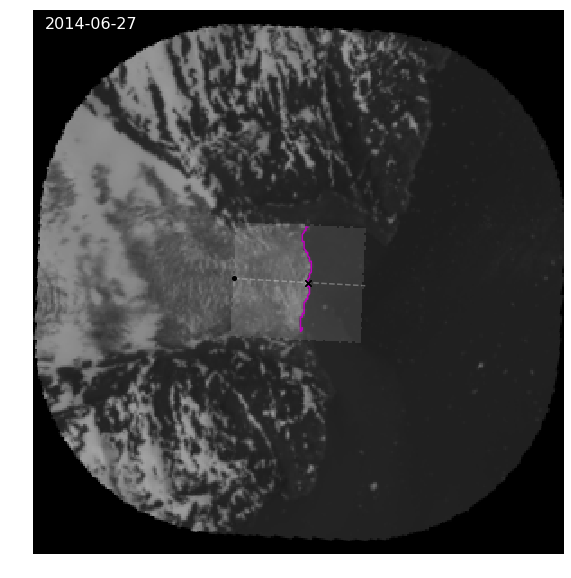

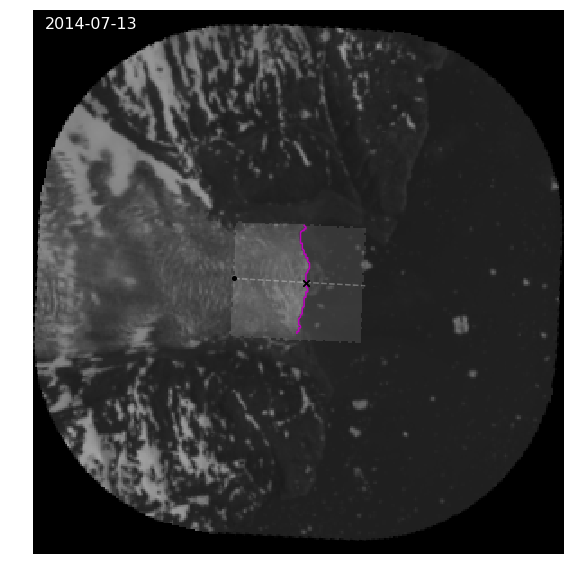

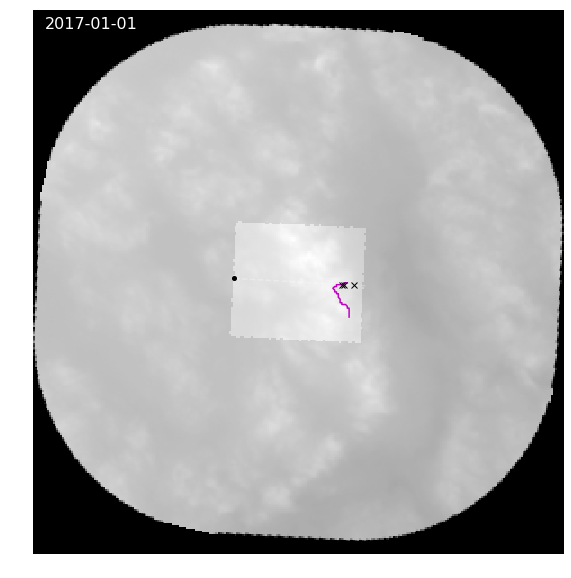

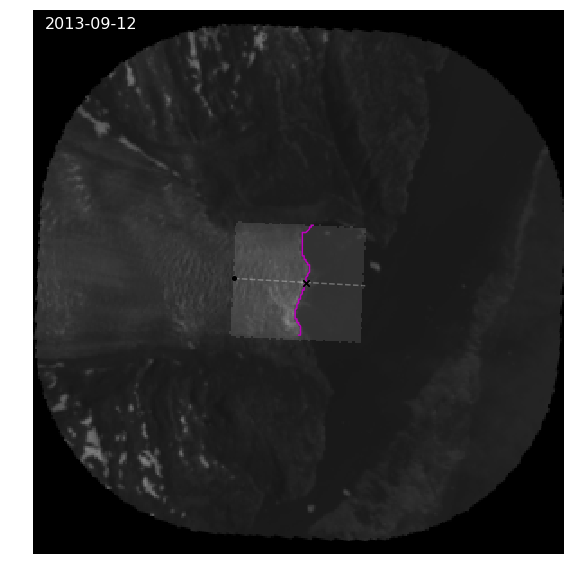

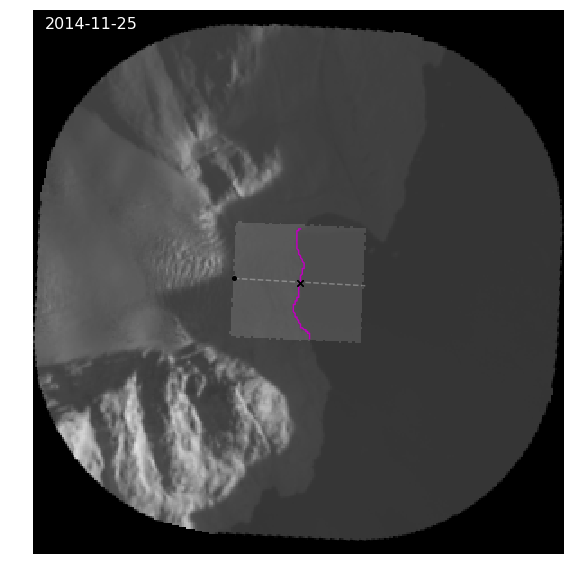

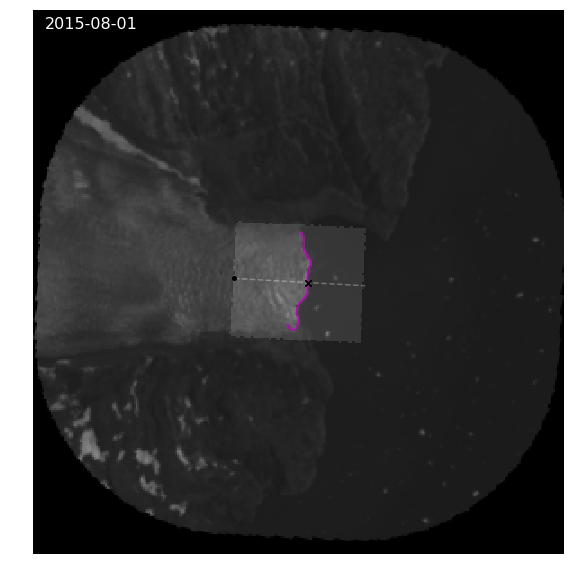

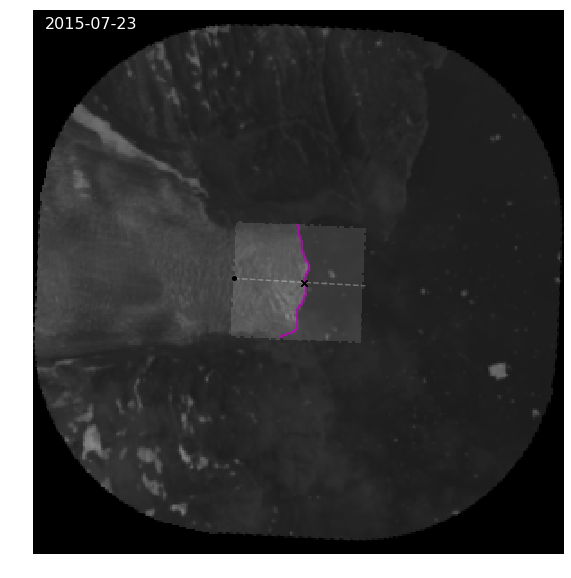

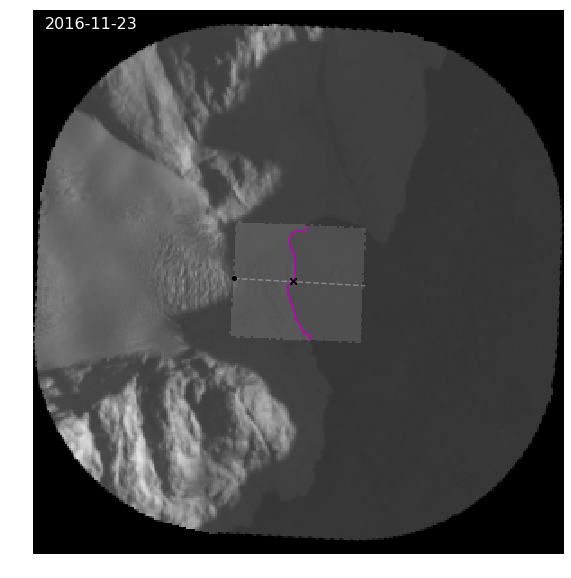

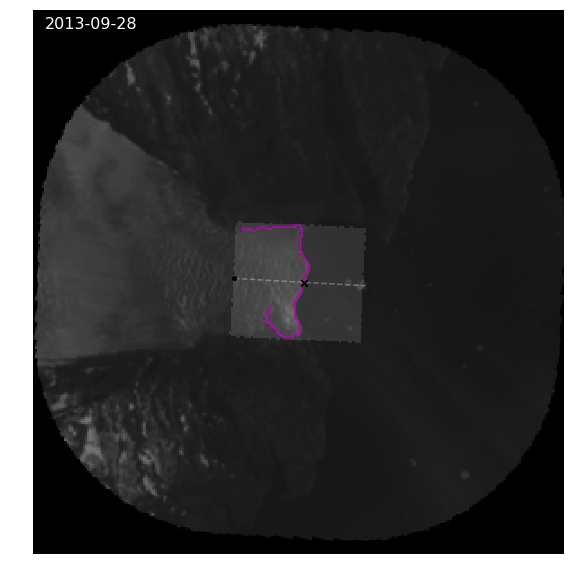

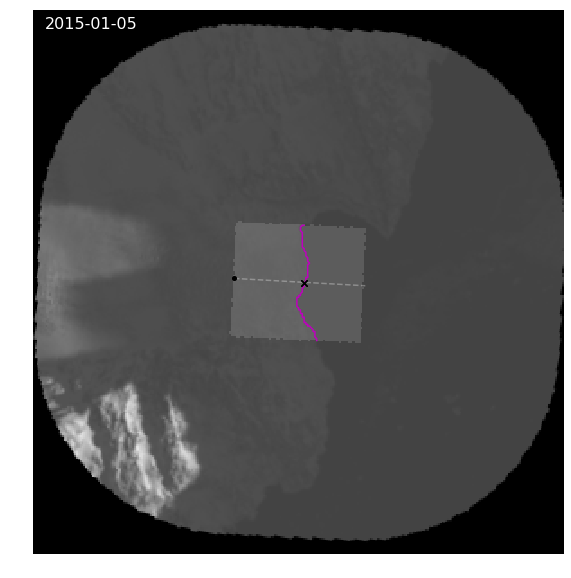

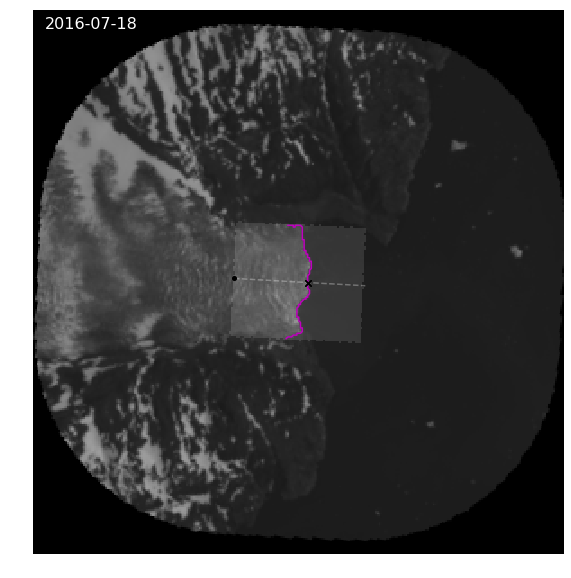

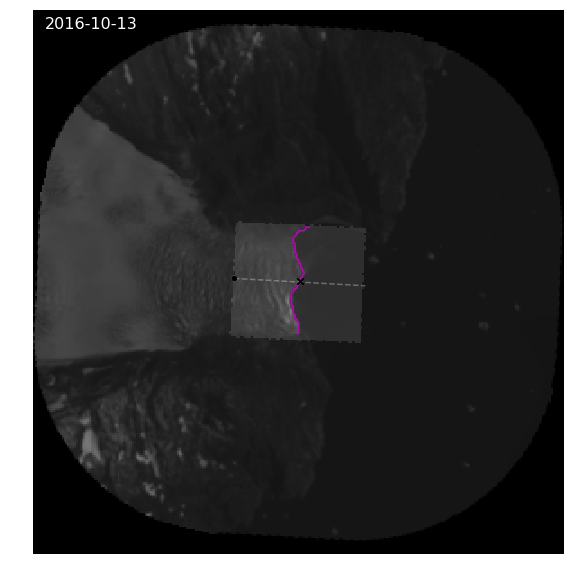

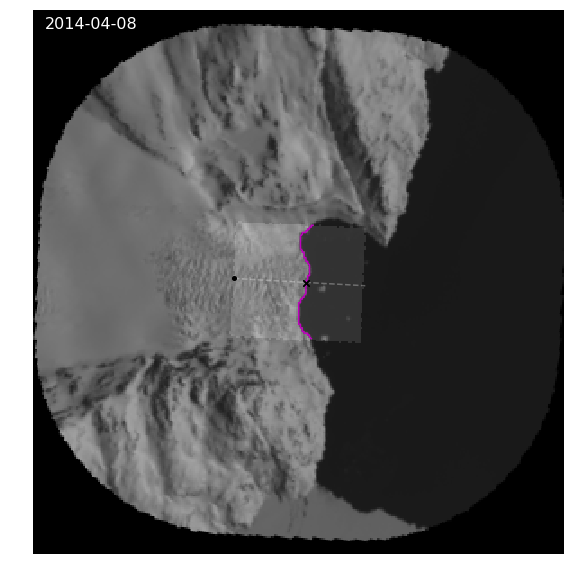

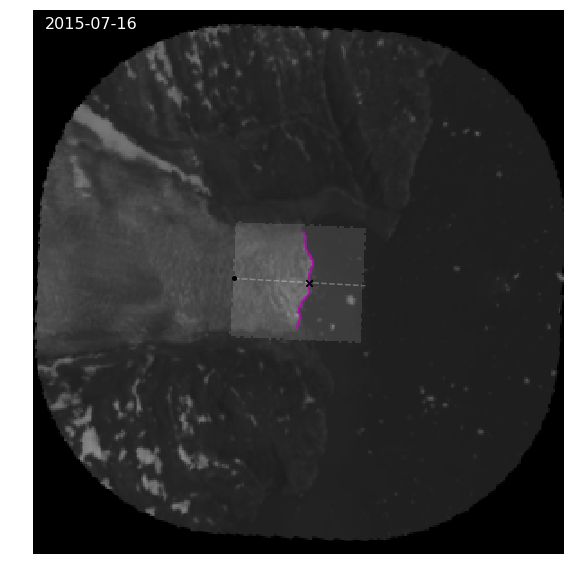

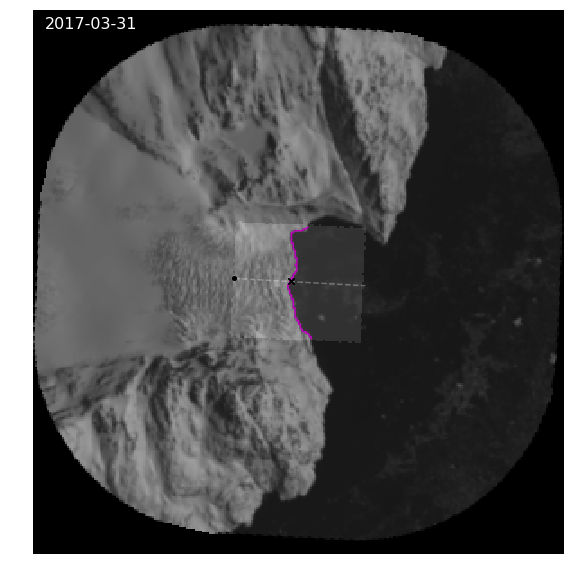

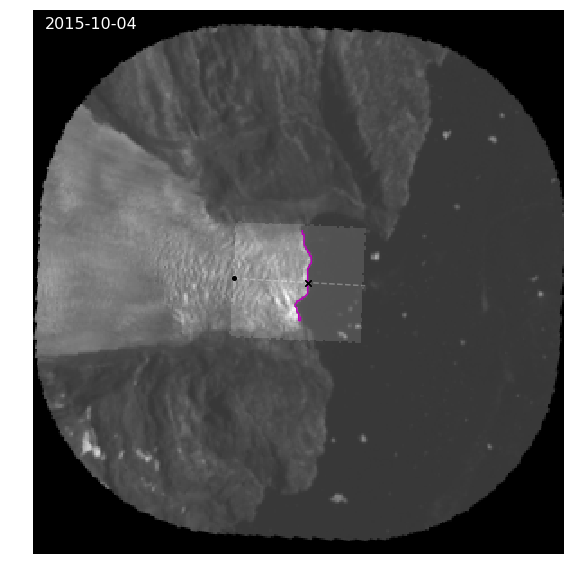

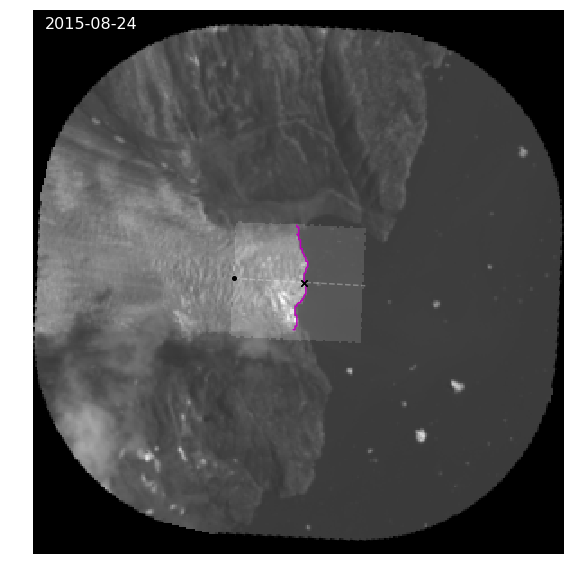

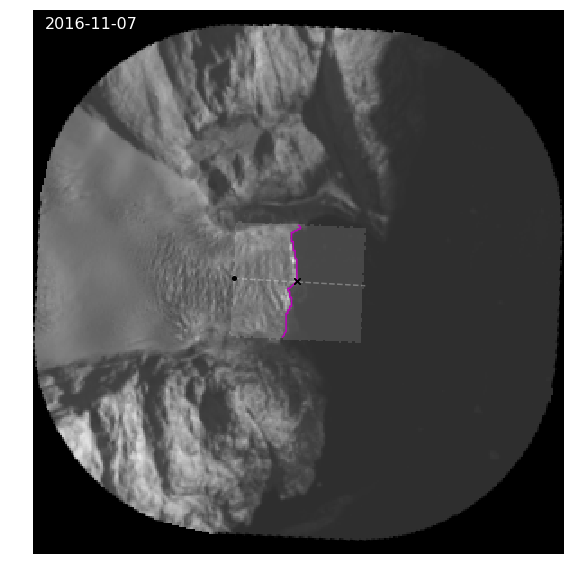

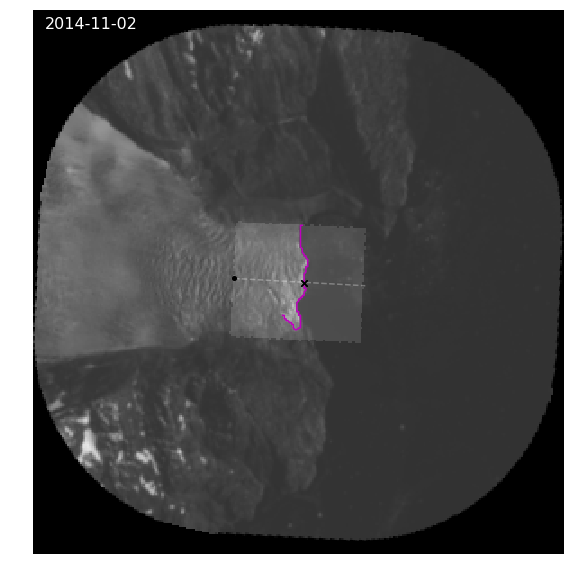

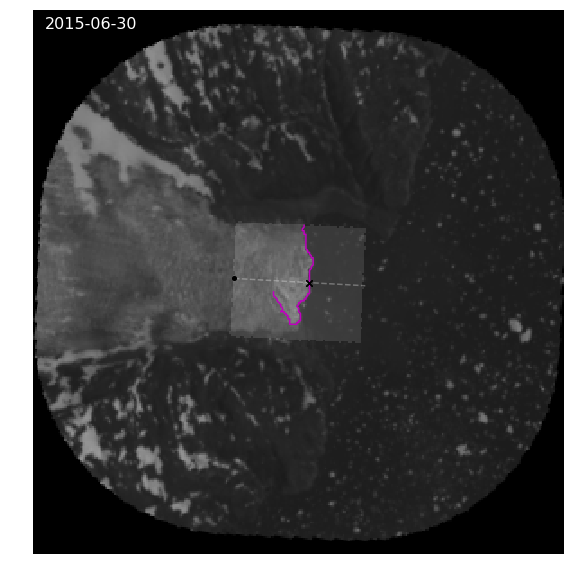

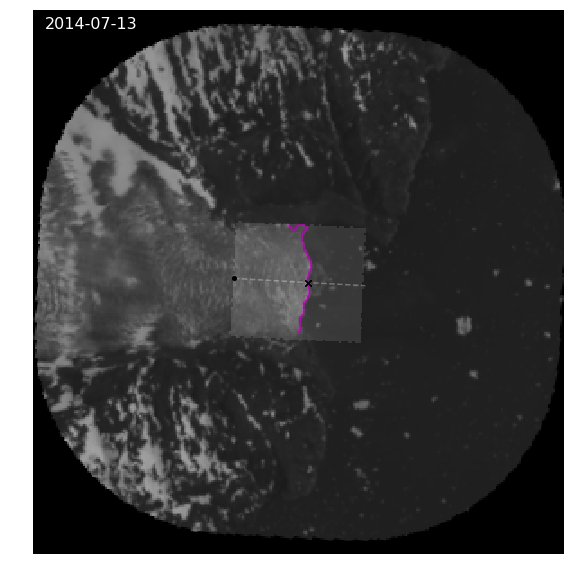

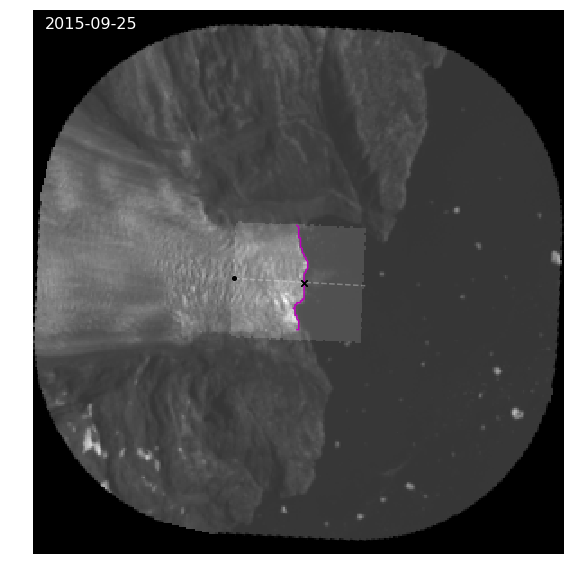

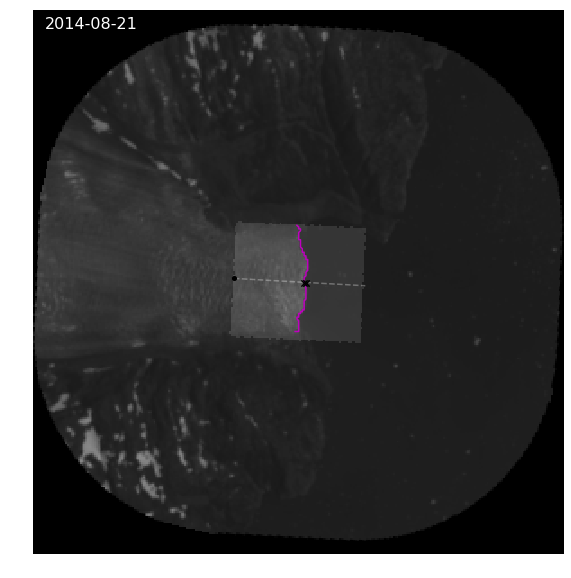

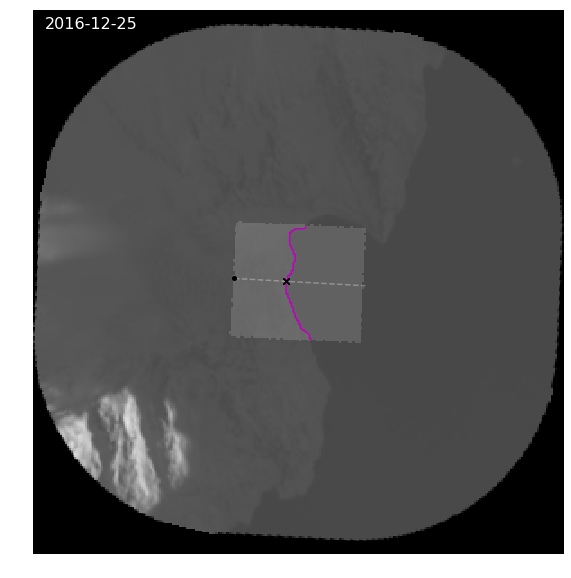

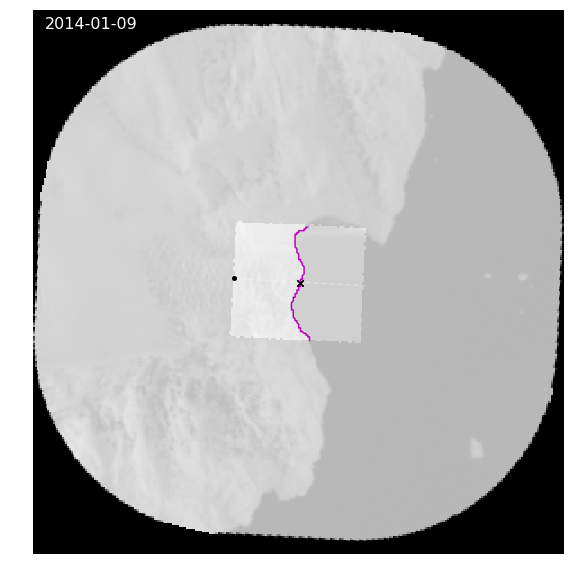

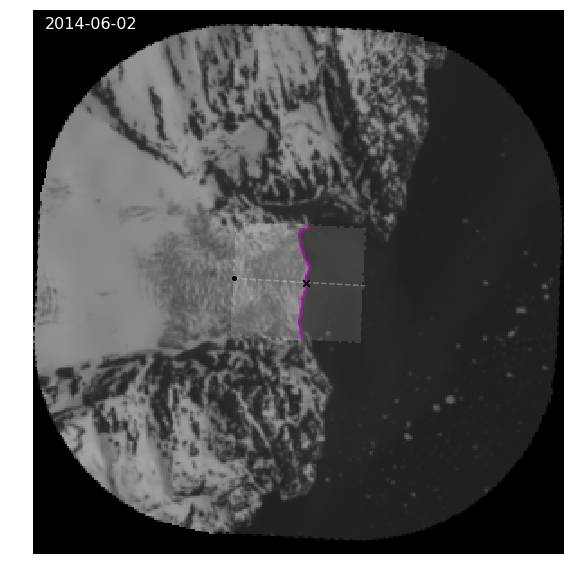

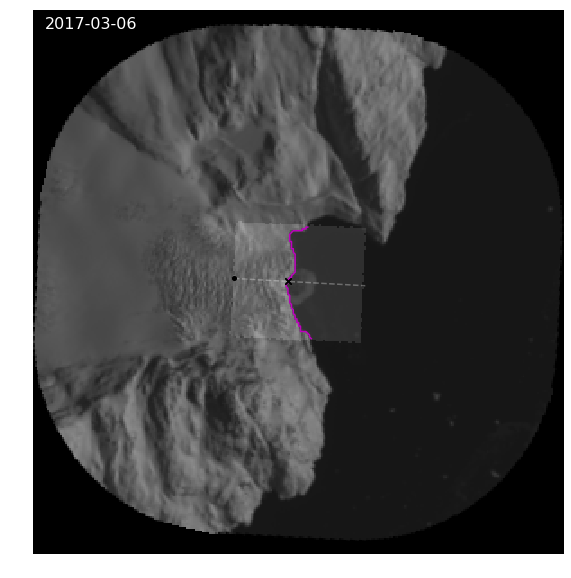

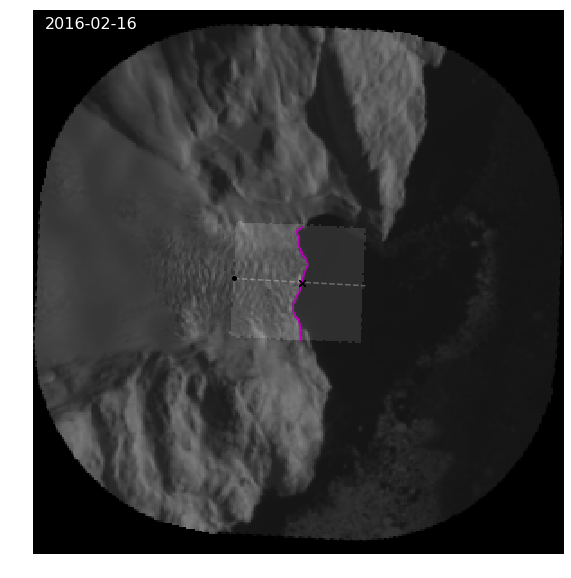

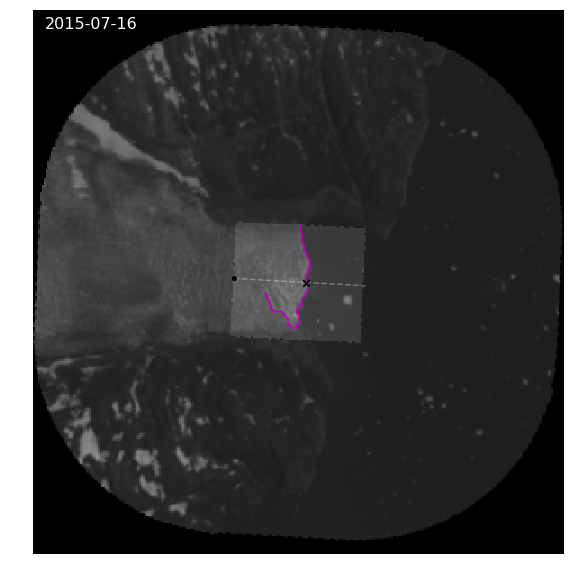

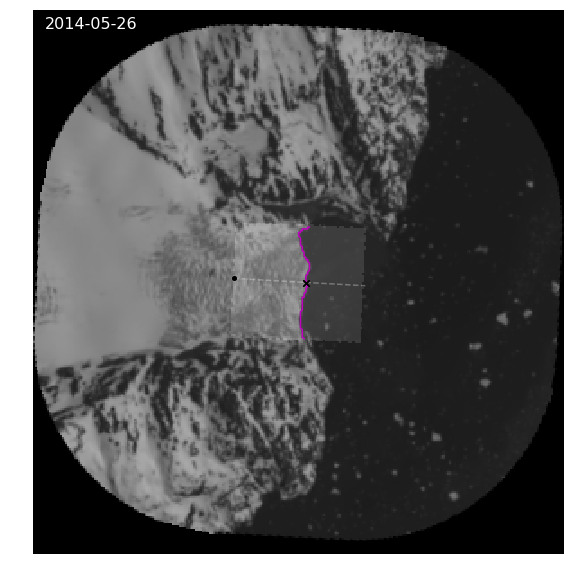

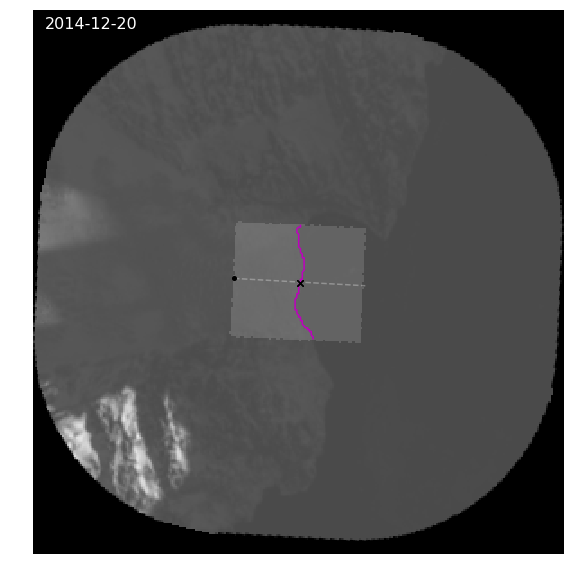

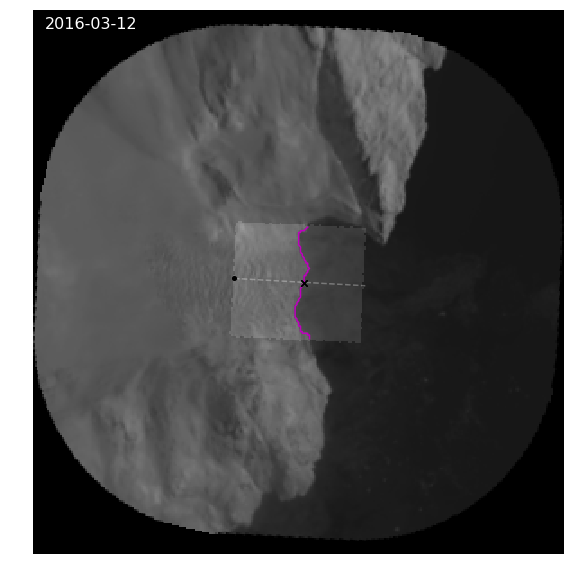

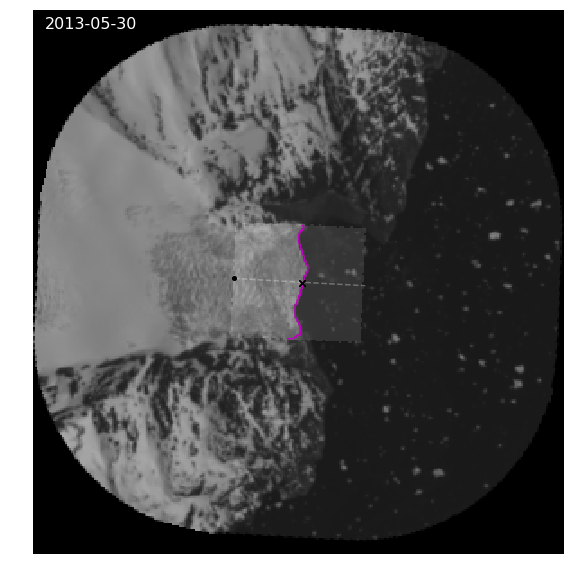

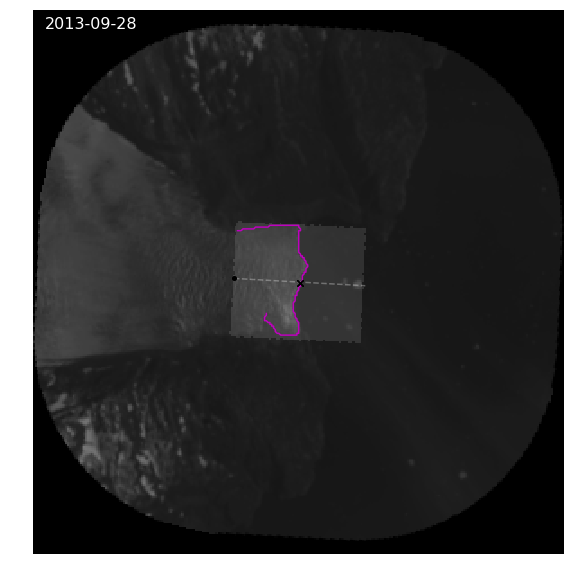

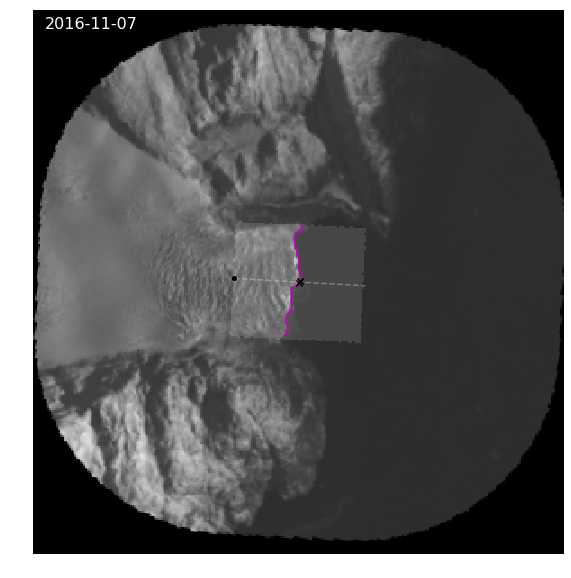

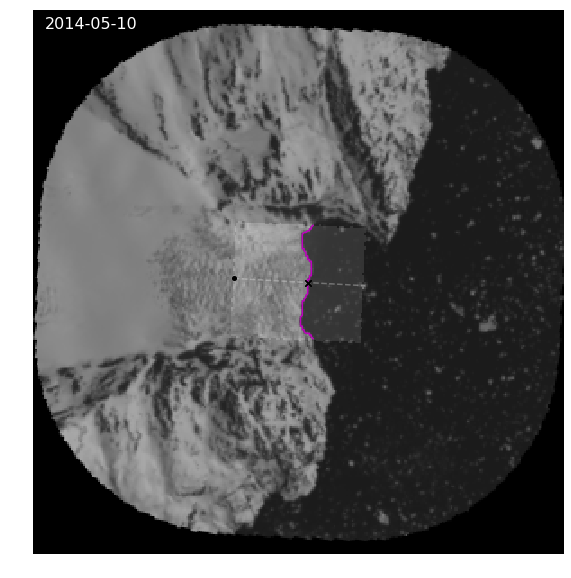

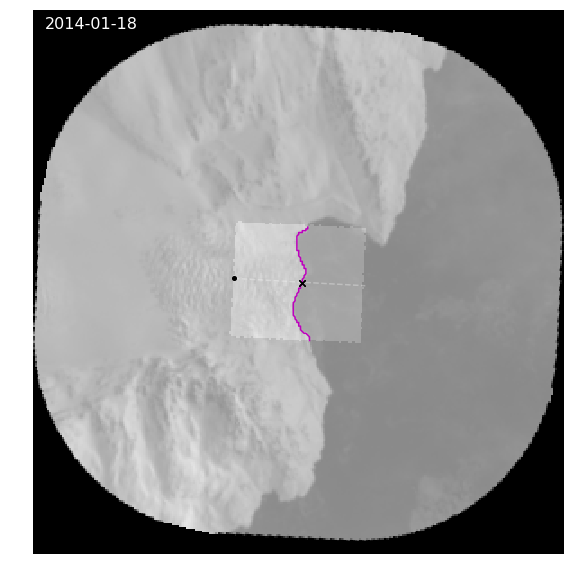

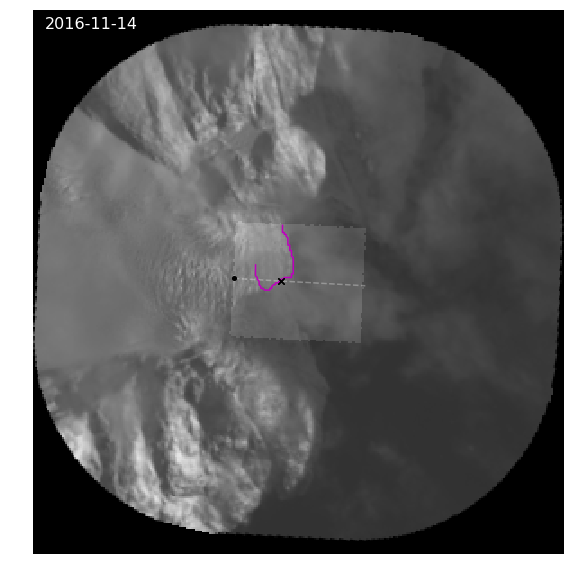

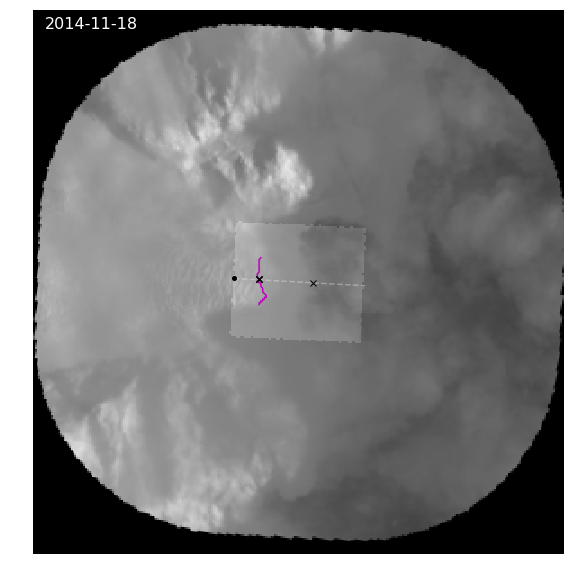

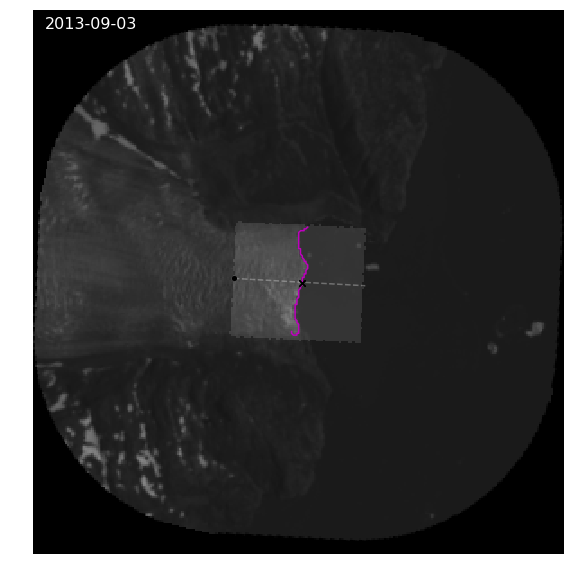

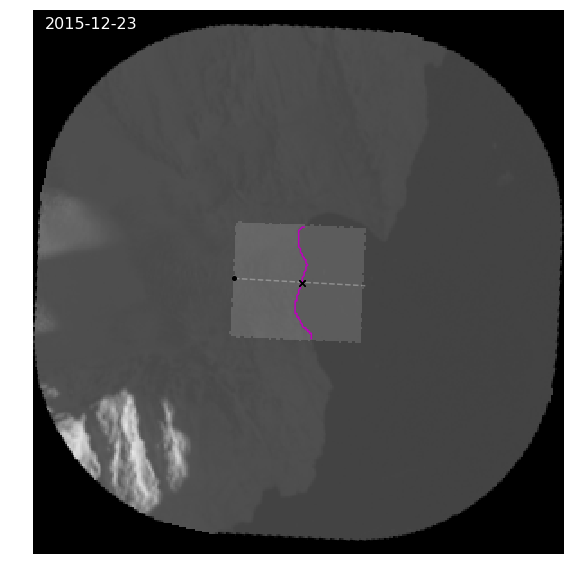

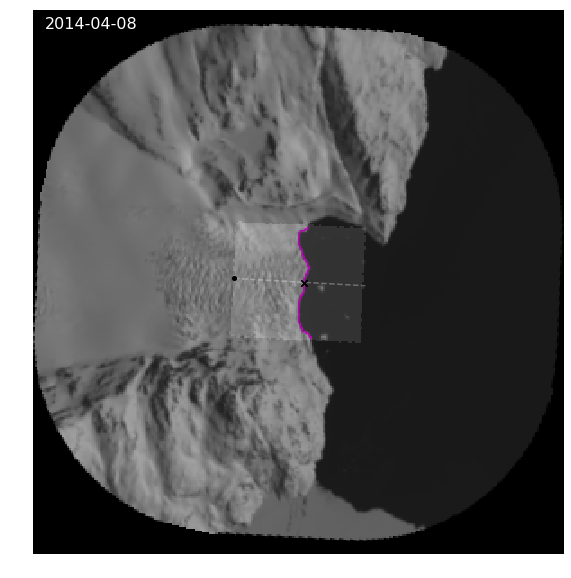

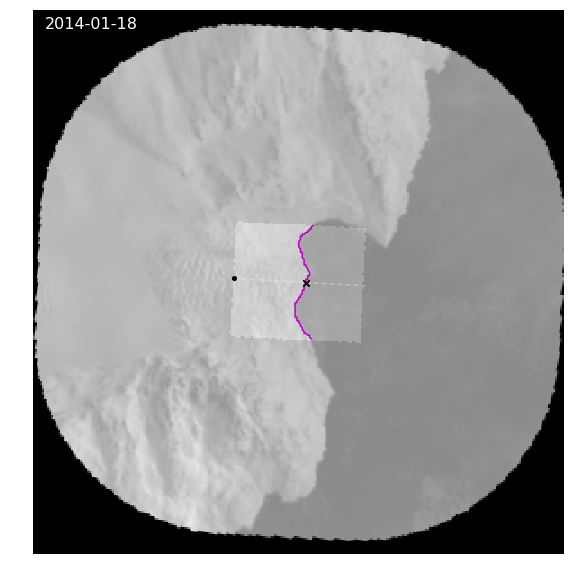

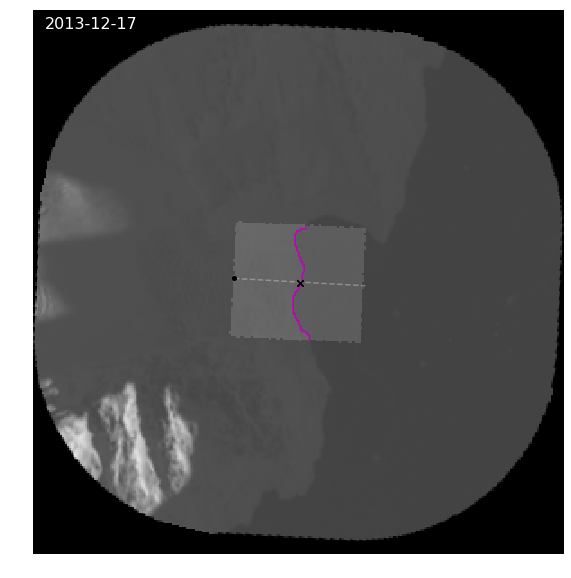

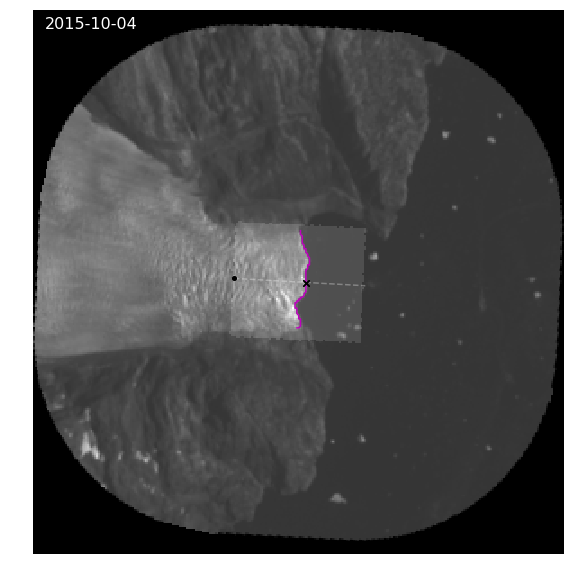

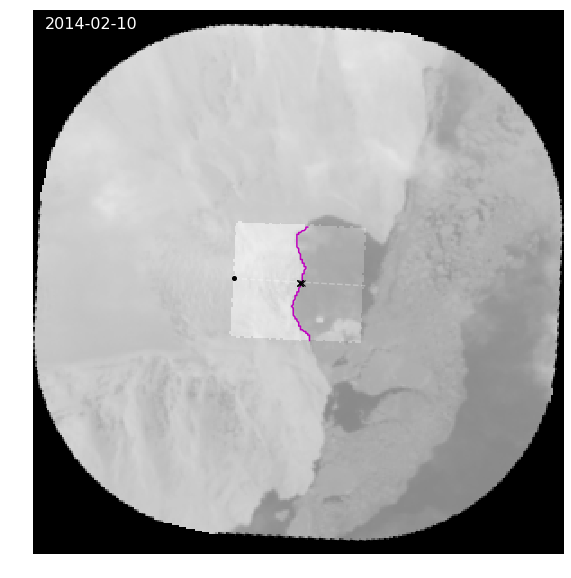

In [244]:
# for index, row in dated_images_df.iterrows():
uniquescenes = set(list(final_images_df['Scene']))
len(uniquescenes)

for scene in uniquescenes:    
    #separate the df by scene:
    scene_df = final_images_df[final_images_df['Scene'] == scene].copy()
    #sort by descending order so the worse orders are plotted first and the better orders are plotted on top
    scene_df = scene_df.sort_values(by='Order', ascending=False)
    
    #grab the date for the scene (just use the first since all should be the same)
    date = list(scene_df.datetimes)[0]
    
    #loop through the rows for each scene
    trimdatfiles = []
    datfiles = []
    orders = []
    intersections = []
    
    for index, row in scene_df.iterrows():
        #grab the terminus_trim files and append to list
        trimdatfiles.append(row['Trimmed_dat_filename'])
        datfiles.append(row['Dat_filename'])
        #grab the order to be plotted later:
        orders.append(row['Order'])
        #grab the intersections to be plotted later:
        intersections.append(row['intersections'])

    #Read in the image.png as np array
    image = mpimg.imread(imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+'.png')
    
    #Read in terminus box raster as an np array
    tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.png")
    
    #set path to that image's datfiles:
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    
    #grab dat xs and ys
    datxs = {}
    datys = {}
    
    for i in range(0, len(trimdatfiles)):
        trimdat = trimdatfiles[i]
        dat = datfiles[i]
#         print(trimdat)
        #Read in dat file as np array and grab x and y values
        term_trim_dat = np.loadtxt(datpath+trimdat)
#         term_dat = np.loadtxt(datpath+dat)
#         print(term_trim_dat.shape)
        
        xs = []
        ys = []
        #grab x and y coordinates for the terminus line
        for j in term_trim_dat:
            x, y = (j[0], j[1])
            xs.append(x)
            ys.append(y)
        
        #update into dat xs and ys dictionaries:
        datxs.update({trimdat: xs})
        datys.update({trimdat: ys})
        
    #PLOT THE LANDSAT IMAGE and TERMINUS BOX
    plt.figure(figsize=(20,10))
    plt.axis("off")
    imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    boxplt = plt.imshow(tbox, alpha=0.1)
    
    #PLOT CENTERLINE
    #grab slope and intercept from the dataframe
    c_slope = float(centerline_df.loc[BOI]['cline_slope'])
    c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
    #grab x values from width of the terminus box array:
    xmin = float(centerline_df.loc[BOI]['midpoint_x'])
    xmax = np.max(np.array(list(set(np.nonzero(tbox)[0]))))
    c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
    c_y = c_slope*c_x + c_intercept
    plt.plot(c_x, c_y, '--w', linewidth=1.5, alpha=0.3)

    #PLOT DATE in the top left corner
    plt.text(int(0.02*image.shape[0]), int(0.035*image.shape[1]), str(date)[:-9], fontsize=16, color='w')
    
    #PLOT TOP PICK in purple
    toppick = trimdatfiles[len(trimdatfiles)-1]
    plt.plot(datxs[toppick], datys[toppick], color='m')
    
    
#     #PLOT ALL TOP PICKS in different shades of purple
#     #create five shades for each order
#     colors = pl.cm.Purples_r(np.linspace(0,1,5))
#     col_count = 0
#     #plot number of lines
#     plt.text(int(0.02*image.shape[0]), int(0.07*image.shape[0]), "Lines: "+str(len(trimdatfiles)), fontsize=16, color='w')
#     #plot each termline
#     for line in trimdatfiles:
#         #grab the x and y values for that termline
#         x, y = datxs[line], datys[line]
#         #plot with color scheme
#         plt.plot(x, y, color=colors[col_count], linewidth=2)
#         col_count = col_count+1
    
    #PLOT intersection points
    for i_point in intersections:
        plt.plot(i_point[0], i_point[1], 'kx', markersize='6')
        
    #PLOT midpoint for figure
    plt.plot(float(centerline_df.loc[BOI]['midpoint_x']), float(centerline_df.loc[BOI]['midpoint_y']), 'ko', markersize='4')
      
    #SAVE AND DELAY
    plt.savefig(basepath+"Box"+BOI+"/Results/"+str(date)[:-9]+"_"+massorsize+"_trim_"+scene+".png", dpi=100, bbox_inches='tight')
#     plt.show()
    
#     sleep(2)
#     clear_output()
# print("Done.")

## 4) Plot terminus position (highest order) and change rate timeseries

### Filtering using max flow speeds:

In [188]:
#Grab max flow threshold from glacier velocities in flowspeed_df
max_flow = float(flowspeed_df['Max_speed'][BOI])
if max_flow < 1.0:
    flow_thresh = 5.0
else:
    flow_thresh = 5.0*max_flow
print(flow_thresh)

5.0


In [189]:
#REMOVE DIPS
dip_indices = []

#reset index for final_images_df
final_images_df = final_images_df.reset_index(drop=True)
# for index, row in onepick_df.iterrows():
for index, row in final_images_df.iterrows():
    rate = row['changerate']
    date = row['datetimes']
    #for negative change rates:
    if rate < 0:
        #make the threshold negative
        flow_thresh = -flow_thresh
        #if it's unrealistic (faster than threshold)
        if rate < flow_thresh:
            #check the next entry only if it's in the range of indices
#             if index+1 < len(onepick_df.index):
            if index+1 < len(final_images_df.index):
                nextrate = final_images_df.loc[index+1]['changerate']
                #if it's a sudden jump, then we have found a dip. Remove it
                if nextrate > abs(flow_thresh):
                    dip_indices.append(index)

print(dip_indices)
filtered_df = final_images_df.drop(dip_indices)

[207, 209, 358, 438, 453]


In [190]:
#RECALCULATE TERMINUS CHANGE RATES
terminus_changerates = []

for i in range(0, len(filtered_df.index)):
    date = list(filtered_df['datetimes'])[i]
    term_position = list(filtered_df['term_position'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(filtered_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis and previous term position
        t_prev = list(filtered_df['datetimes'])[i-1]
        x_prev = list(filtered_df['term_position'])[i-1]
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        if delta_t == 0:
            changerate = 0
        else:
            changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)
#     print(changerate)

filtered_df['changerate'] = terminus_changerates

In [191]:
#FILTER unrealistic advances
jump_indices = []

for i in range(0, len(filtered_df.index)):
    date = list(filtered_df['datetimes'])[i]
    rate = list(filtered_df['changerate'])[i]
    index = list(filtered_df.index)[i]
 
    if rate > abs(flow_thresh):
        #remove it:
        jump_indices.append(index)
    
    #remove drops if they are due to first value for the season
    prev_date = list(filtered_df['datetimes'])[i-1]
    delta_date = date - prev_date
    delta_date = delta_date.days
            
    #if the time jump is more than 2, remove it.
    if delta_date > 60:
        jump_indices.append(index)
print(jump_indices)

filtered2_df = filtered_df.drop(jump_indices)

[10, 170, 245, 249, 359, 439, 454]


In [192]:
filtered2_df.shape

(485, 12)

Grab only those terminus positions corresponding to the highest order terminus pick.

In [193]:
#grab unique dates
unique_dates = set(list(filtered2_df['datetimes']))
print(len(unique_dates))
#grab highest order:
order_list = []
for date in unique_dates:
    date_df = filtered2_df[filtered2_df['datetimes'] == date].copy()
    highestorder = np.min(np.array(date_df['Order']))
    order_list.append(highestorder)

#create highestorder_df
highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order'])
highestorder_df = highestorder_df.sort_values(by='datetimes', ascending=True)
highestorder_df.head()

71


datetimes Order
11 2013-04-12     1
0  2013-05-30     1
55 2013-08-18     2
43 2013-09-03     1
56 2013-09-12     1

Inner merge with final_images_df to only keep those of the highest order

In [194]:
onepick_df = filtered2_df.merge(highestorder_df, how='inner', on=['datetimes', 'Order'])
print(onepick_df.shape[0])
onepick_df

98


Scene BoxID  \
0   LC82330172013102LGN01   120   
1   LC82330172013150LGN00   120   
2   LC82330172013230LGN00   120   
3   LC82330172013246LGN00   120   
4   LC82320172013255LGN00   120   
5   LC82320182013255LGN00   120   
6   LC82320172013271LGN00   120   
7   LC82320182013271LGN00   120   
8   LC82330172013294LGN00   120   
9   LC82330172013310LGN00   120   
10  LC82320182013335LGN00   120   
11  LC82320182013351LGN00   120   
12  LC82330172014009LGN00   120   
13  LC82320172014018LGN00   120   
14  LC82320182014018LGN00   120   
15  LC82330172014041LGN00   120   
16  LC82320172014066LGN00   120   
17  LC82320182014066LGN00   120   
18  LC82320172014098LGN00   120   
19  LC82320182014098LGN00   120   
20  LC82320172014130LGN00   120   
21  LC82320182014130LGN00   120   
22  LC82330172014137LGN00   120   
23  LC82320172014146LGN00   120   
24  LC82320182014146LGN00   120   
25  LC82330172014153LGN00   120   
26  LC82320172014178LGN00   120   
27  LC82320182014178LGN00   120   
28  LC82320172014194LGN00   120   
29  LC82320182014194LGN00   120   
..                    ...   ...   
68  LC82320182015341LGN00   120   
69  LC82320182015357LGN00   120   
70  LC82330172016015LGN00   120   
71  LC82330172016047LGN00   120   
72  LC82320172016072LGN00   120   
73  LC82320182016072LGN00   120   
74  LC82320172016104LGN00   120   
75  LC82320182016104LGN00   120   
76  LC82330172016127LGN00   120   
77  LC82330172016175LGN00   120   
78  LC82320172016200LGN00   120   
79  LC82320182016200LGN00   120   
80  LC82330172016255LGN00   120   
81  LC82330172016271LGN00   120   
82  LC82330172016287LGN00   120   
83  LC82330172016303LGN00   120   
84  LC82320172016312LGN00   120   
85  LC82320182016312LGN00   120   
86  LC82330172016319LGN00   120   
87  LC82320182016328LGN00   120   
88  LC82320182016360LGN00   120   
89  LC82330172017001LGN00   120   
90  LC82330172017017LGN00   120   
91  LC82320172017026LGN00   120   
92  LC82320182017026LGN00   120   
93  LC82330172017065LGN00   120   
94  LC82320172017074LGN00   120   
95  LC82320182017074LGN00   120   
96  LC82320172017090LGN00   120   
97  LC82320182017090LGN00   120   

                                          Image_array      Dat_filename  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
12  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
13  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
15  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
16  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
17  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
18  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
19  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
20  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
21  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
22  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
23  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Re-calculate and filter again for unrealistic advances:

In [195]:
#RECALCULATE TERMINUS CHANGE RATES
terminus_changerates = []

for i in range(0, len(onepick_df.index)):
    date = list(onepick_df['datetimes'])[i]
    term_position = list(onepick_df['term_position'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(onepick_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis and previous term position
        t_prev = list(filtered_df['datetimes'])[i-1]
        x_prev = list(filtered_df['term_position'])[i-1]
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        if delta_t == 0:
            changerate = 0
        else:
            changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)
#     print(changerate)

onepick_df['changerate'] = terminus_changerates

#FILTER unrealistic advances
jump_indices = []

for i in range(0, len(onepick_df.index)):
    date = list(onepick_df['datetimes'])[i]
    rate = list(onepick_df['changerate'])[i]
    index = list(onepick_df.index)[i]
 
    if rate > abs(flow_thresh):
        #remove it:
        jump_indices.append(index)
    
    #remove drops if they are due to first value for the season
    prev_date = list(onepick_df['datetimes'])[i-1]
    delta_date = date - prev_date
    delta_date = delta_date.days
            
    #if the time jump is more than 2, remove it.
    if delta_date > 60:
        jump_indices.append(index)
print(jump_indices)

filtered3_df = onepick_df.drop(jump_indices)
print(len(filtered3_df.index))

[2, 49]
96


## Plotting:

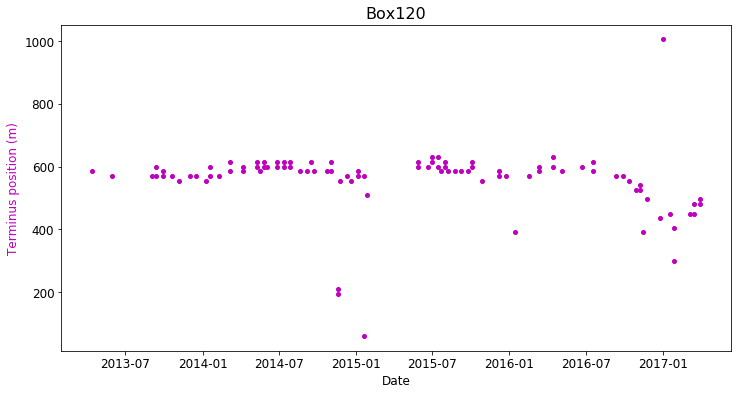

In [196]:
fig, ax1 = plt.subplots(figsize=(12,6))

#TERMINUS POSITION
ax1.plot(filtered3_df['datetimes'], filtered3_df['term_position'], 'mo', markersize='4')
# ax1 = onepick_df.plot(x='datetimes', y='term_position', color='m', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
ax1.set_ylabel('Terminus position (m)', color='m', fontsize=12)

#TERMINUS CHANGE RATES
# ax2 = ax1.twinx()
# ax2.plot(onepick_df['datetimes'], onepick_df['changerate'], 'bo', markersize='4')
# ax2.set_ylabel('Terminus change rate (m/d)', color = 'b', fontsize=12)

#GENERAL PLOT PARAMETERS
ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax2.tick_params(axis='both', which='major', labelsize=12)


#SAVE FIGURE
plt.savefig(csvpaths+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+analysis_date+".png", dpi=200)

plt.show()

In [98]:
filtered3_df.to_csv(path_or_buf = csvpaths+'Term_position_timeseries_Box'+BOI+'.csv', sep=',')